In [251]:
import pandas as pd
import requests
import random
from time import sleep
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import nltk
import os
from sklearn import datasets
from sklearn.metrics import mean_squared_error
import datetime
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import learning_curve
import matplotlib.style as style

%matplotlib inline
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [252]:
df = pd.read_pickle("Data/Fitbit_and_MFP_Cleaned.pkl")

df.reset_index(inplace=True)

df.head(50)

,Date,Steps,Distance,Calories_Burned,Floors,Elevation,Activity_Calories,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,...,Fiber_Dinner,Sugar_Dinner,Protein_(g)_Dinner,Vitamin_A_Dinner,Vitamin_C_Dinner,Calcium_Dinner,Iron_Dinner,Weight,Net_Calories,Day_of_week
0,2016-12-16,7949.359551,6.100120,1856.0,6.528090,19.629213,1059.067416,1440.0,180.853933,8.977528,...,4.801786,9.191071,39.676786,9.469643,16.176786,9.782143,11.300000,NaN,NaN,Friday
1,2016-12-17,5514.820225,4.235007,1855.0,7.089888,21.438202,781.202247,1440.0,102.426966,13.404494,...,4.600000,9.650000,42.591176,13.979412,20.058824,25.000000,24.091176,NaN,NaN,Saturday
2,2016-12-18,4782.921348,3.679812,1855.0,5.146067,15.494382,702.179775,1440.0,85.123596,12.157303,...,5.353488,10.444186,45.627907,17.386047,54.534884,10.860465,23.369767,NaN,-1110.2,Sunday
3,2016-12-19,6743.966292,5.175902,1855.0,4.640449,13.977528,869.786517,1440.0,127.393258,9.348315,...,10.000000,15.000000,5.000000,40.000000,125.000000,10.000000,10.000000,186.800000,-660.1,Monday
4,2016-12-20,7318.181818,5.671428,1854.0,5.215909,15.704545,911.261364,1440.0,148.397727,8.636364,...,1.900000,14.100000,47.700000,18.000000,48.800000,2.500000,25.400000,186.483333,-154.3,Tuesday
5,2016-12-21,7112.386364,5.472372,1854.0,3.909091,11.761364,899.102273,1440.0,155.465909,7.477273,...,4.378022,8.345055,42.856044,11.289011,16.280220,11.697802,21.106593,186.166667,-978.3,Wednesday
6,2016-12-22,7365.511364,5.715491,1854.0,4.420455,13.284091,857.477273,1440.0,145.545455,6.340909,...,4.000000,6.942857,31.000000,9.000000,12.935065,24.000000,23.000000,185.850000,-142.5,Thursday
7,2016-12-23,7949.359551,6.100120,1853.0,6.528090,19.629213,1059.067416,1440.0,180.853933,8.977528,...,4.801786,9.191071,39.676786,9.469643,16.176786,9.782143,11.300000,185.533333,-1036.9,Friday
8,2016-12-24,5514.820225,4.235007,1853.0,7.089888,21.438202,781.202247,1440.0,102.426966,13.404494,...,4.600000,9.650000,42.591176,13.979412,20.058824,25.000000,24.091176,185.216667,-903.0,Saturday
9,2016-12-25,1178.000000,0.882320,2074.0,3.000000,9.000000,268.000000,1368.0,72.000000,12.157303,...,5.353488,10.444186,45.627907,17.386047,54.534884,10.860465,23.369767,184.900000,NaN,Sunday


## USE YESTERDAY'S ACTIVITY/INTAKE TO PREDICT TODAY'S WEIGHT

In [253]:
## SHIFT DAYS ONE TO USE YESTERDAY'S Activity/Nutritional Info TO PREDICT TODAYS WEIGHTS

df.Date = df.Date.shift(-1)

df.Date.iloc[619] = datetime.date(2018, 8, 28)

df

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Date,Steps,Distance,Calories_Burned,Floors,Elevation,Activity_Calories,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,...,Fiber_Dinner,Sugar_Dinner,Protein_(g)_Dinner,Vitamin_A_Dinner,Vitamin_C_Dinner,Calcium_Dinner,Iron_Dinner,Weight,Net_Calories,Day_of_week
0,2016-12-17,7949.359551,6.100120,1856.0,6.528090,19.629213,1059.067416,1440.0,180.853933,8.977528,...,4.801786,9.191071,39.676786,9.469643,16.176786,9.782143,11.300000,NaN,NaN,Friday
1,2016-12-18,5514.820225,4.235007,1855.0,7.089888,21.438202,781.202247,1440.0,102.426966,13.404494,...,4.600000,9.650000,42.591176,13.979412,20.058824,25.000000,24.091176,NaN,NaN,Saturday
2,2016-12-19,4782.921348,3.679812,1855.0,5.146067,15.494382,702.179775,1440.0,85.123596,12.157303,...,5.353488,10.444186,45.627907,17.386047,54.534884,10.860465,23.369767,NaN,-1110.2,Sunday
3,2016-12-20,6743.966292,5.175902,1855.0,4.640449,13.977528,869.786517,1440.0,127.393258,9.348315,...,10.000000,15.000000,5.000000,40.000000,125.000000,10.000000,10.000000,186.800000,-660.1,Monday
4,2016-12-21,7318.181818,5.671428,1854.0,5.215909,15.704545,911.261364,1440.0,148.397727,8.636364,...,1.900000,14.100000,47.700000,18.000000,48.800000,2.500000,25.400000,186.483333,-154.3,Tuesday
5,2016-12-22,7112.386364,5.472372,1854.0,3.909091,11.761364,899.102273,1440.0,155.465909,7.477273,...,4.378022,8.345055,42.856044,11.289011,16.280220,11.697802,21.106593,186.166667,-978.3,Wednesday
6,2016-12-23,7365.511364,5.715491,1854.0,4.420455,13.284091,857.477273,1440.0,145.545455,6.340909,...,4.000000,6.942857,31.000000,9.000000,12.935065,24.000000,23.000000,185.850000,-142.5,Thursday
7,2016-12-24,7949.359551,6.100120,1853.0,6.528090,19.629213,1059.067416,1440.0,180.853933,8.977528,...,4.801786,9.191071,39.676786,9.469643,16.176786,9.782143,11.300000,185.533333,-1036.9,Friday
8,2016-12-25,5514.820225,4.235007,1853.0,7.089888,21.438202,781.202247,1440.0,102.426966,13.404494,...,4.600000,9.650000,42.591176,13.979412,20.058824,25.000000,24.091176,185.216667,-903.0,Saturday
9,2016-12-26,1178.000000,0.882320,2074.0,3.000000,9.000000,268.000000,1368.0,72.000000,12.157303,...,5.353488,10.444186,45.627907,17.386047,54.534884,10.860465,23.369767,184.900000,NaN,Sunday


In [254]:
## INTERPOLATING WEIGHTS THAT ARE MISSING

df.Weight = df.Weight.interpolate(method='linear')
df.drop('Day_of_week', axis=1, inplace=True)

df.head(562)

,Date,Steps,Distance,Calories_Burned,Floors,Elevation,Activity_Calories,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,...,Carbohydrates_(g)_Dinner,Fiber_Dinner,Sugar_Dinner,Protein_(g)_Dinner,Vitamin_A_Dinner,Vitamin_C_Dinner,Calcium_Dinner,Iron_Dinner,Weight,Net_Calories
0,2016-12-17,7949.359551,6.100120,1856.0,6.528090,19.629213,1059.067416,1440.0,180.853933,8.977528,...,52.296429,4.801786,9.191071,39.676786,9.469643,16.176786,9.782143,11.300000,NaN,NaN
1,2016-12-18,5514.820225,4.235007,1855.0,7.089888,21.438202,781.202247,1440.0,102.426966,13.404494,...,59.961765,4.600000,9.650000,42.591176,13.979412,20.058824,25.000000,24.091176,NaN,NaN
2,2016-12-19,4782.921348,3.679812,1855.0,5.146067,15.494382,702.179775,1440.0,85.123596,12.157303,...,71.923256,5.353488,10.444186,45.627907,17.386047,54.534884,10.860465,23.369767,NaN,-1110.2
3,2016-12-20,6743.966292,5.175902,1855.0,4.640449,13.977528,869.786517,1440.0,127.393258,9.348315,...,30.000000,10.000000,15.000000,5.000000,40.000000,125.000000,10.000000,10.000000,186.800000,-660.1
4,2016-12-21,7318.181818,5.671428,1854.0,5.215909,15.704545,911.261364,1440.0,148.397727,8.636364,...,44.000000,1.900000,14.100000,47.700000,18.000000,48.800000,2.500000,25.400000,186.483333,-154.3
5,2016-12-22,7112.386364,5.472372,1854.0,3.909091,11.761364,899.102273,1440.0,155.465909,7.477273,...,56.232967,4.378022,8.345055,42.856044,11.289011,16.280220,11.697802,21.106593,186.166667,-978.3
6,2016-12-23,7365.511364,5.715491,1854.0,4.420455,13.284091,857.477273,1440.0,145.545455,6.340909,...,72.000000,4.000000,6.942857,31.000000,9.000000,12.935065,24.000000,23.000000,185.850000,-142.5
7,2016-12-24,7949.359551,6.100120,1853.0,6.528090,19.629213,1059.067416,1440.0,180.853933,8.977528,...,52.296429,4.801786,9.191071,39.676786,9.469643,16.176786,9.782143,11.300000,185.533333,-1036.9
8,2016-12-25,5514.820225,4.235007,1853.0,7.089888,21.438202,781.202247,1440.0,102.426966,13.404494,...,59.961765,4.600000,9.650000,42.591176,13.979412,20.058824,25.000000,24.091176,185.216667,-903.0
9,2016-12-26,1178.000000,0.882320,2074.0,3.000000,9.000000,268.000000,1368.0,72.000000,12.157303,...,71.923256,5.353488,10.444186,45.627907,17.386047,54.534884,10.860465,23.369767,184.900000,NaN


In [256]:
sixty_percent = int(np.ceil(0.95*len(df)))

train_df = df[:575]

holdout_df = df[575:]

In [257]:
prophet = Prophet(mcmc_samples=100,changepoint_range=0.9)

pro_train_df = train_df[['Date','Weight']]

pro_train_df.rename(columns={"Date": "ds", "Weight": "y"}, inplace=True)

pro_train_df

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,ds,y
0,2016-12-17,NaN
1,2016-12-18,NaN
2,2016-12-19,NaN
3,2016-12-20,186.800000
4,2016-12-21,186.483333
5,2016-12-22,186.166667
6,2016-12-23,185.850000
7,2016-12-24,185.533333
8,2016-12-25,185.216667
9,2016-12-26,184.900000


In [258]:
df['Steps']

0       7949.359551
1       5514.820225
2       4782.921348
3       6743.966292
4       7318.181818
5       7112.386364
6       7365.511364
7       7949.359551
8       5514.820225
9       1178.000000
10      4058.000000
11      6378.000000
12      9507.000000
13      6472.000000
14      2989.000000
15       784.000000
16       137.000000
17      4791.000000
18      5224.000000
19      7864.000000
20      4709.000000
21     13146.000000
22      3002.000000
23      4392.000000
24      5423.000000
25     10152.000000
26      9289.000000
27      6284.000000
28     13866.000000
29      5606.000000
           ...     
590     4782.921348
591     6743.966292
592     3985.000000
593     4173.000000
594     7469.000000
595    10066.000000
596     8927.000000
597     2260.000000
598     7036.000000
599    10049.000000
600     9404.000000
601     3897.000000
602     7947.000000
603     3713.000000
604     9530.000000
605     9455.000000
606     5213.000000
607      284.000000
608     7299.000000


In [259]:
train_extra_df = train_df[['Steps','Minutes_Sedentary', 'Minutes_Lightly_Active',
       'Minutes_Fairly_Active', 'Minutes_Very_Active', 'Calories_Breakfast',
       'Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast',
       'Sodium_(mg)_Breakfast',
       'Protein_(g)_Breakfast', 'Calories_Lunch', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Sodium_(mg)_Lunch',
       'Carbohydrates_(g)_Lunch', 'Sugar_Lunch', 'Protein_(g)_Lunch',
       'Calories_Dinner', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner',
       'Sodium_(mg)_Dinner', 'Carbohydrates_(g)_Dinner',
       'Sugar_Dinner', 'Protein_(g)_Dinner']]

extra_regressors = ['Steps','Minutes_Sedentary', 'Minutes_Lightly_Active',
       'Minutes_Fairly_Active', 'Minutes_Very_Active', 'Calories_Breakfast',
       'Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast',
       'Sodium_(mg)_Breakfast',
       'Protein_(g)_Breakfast', 'Calories_Lunch', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Sodium_(mg)_Lunch',
       'Carbohydrates_(g)_Lunch', 'Sugar_Lunch', 'Protein_(g)_Lunch',
       'Calories_Dinner', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner',
       'Sodium_(mg)_Dinner', 'Carbohydrates_(g)_Dinner',
       'Sugar_Dinner', 'Protein_(g)_Dinner']

for i in extra_regressors:
    pro_train_df[i] = train_extra_df[i]

pro_train_df

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ds,y,Steps,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Calories_Breakfast,Saturated_Fat_Breakfast,Cholesterol_Breakfast,...,Calories_Dinner,Saturated_Fat_Dinner,Polyunsaturated_Fat_Dinner,Monounsaturated_Fat_Dinner,Trans_Fat_Dinner,Cholesterol_Dinner,Sodium_(mg)_Dinner,Carbohydrates_(g)_Dinner,Sugar_Dinner,Protein_(g)_Dinner
0,2016-12-17,NaN,7949.359551,1440.0,180.853933,8.977528,16.202247,374.499107,5.857143,103.657143,...,612.128571,7.269643,0.666071,1.314286,0.255357,114.707143,1050.707143,52.296429,9.191071,39.676786
1,2016-12-18,NaN,5514.820225,1440.0,102.426966,13.404494,23.292135,531.626667,9.585333,351.065333,...,686.482353,12.223529,0.697059,0.744118,0.282353,100.432353,1114.300000,59.961765,9.650000,42.591176
2,2016-12-19,NaN,4782.921348,1440.0,85.123596,12.157303,24.078652,352.400000,7.700000,45.000000,...,864.811628,11.144186,1.827907,5.158140,0.286047,147.553488,1565.016279,71.923256,10.444186,45.627907
3,2016-12-20,186.800000,6743.966292,1440.0,127.393258,9.348315,23.853933,244.400000,3.000000,20.000000,...,175.000000,7.760870,1.098551,2.750725,0.644928,127.798551,125.000000,30.000000,15.000000,5.000000
4,2016-12-21,186.483333,7318.181818,1440.0,148.397727,8.636364,17.397727,520.000000,3.000000,20.000000,...,519.700000,2.300000,0.300000,2.720430,0.054839,90.000000,4337.200000,44.000000,14.100000,47.700000
5,2016-12-22,186.166667,7112.386364,1440.0,155.465909,7.477273,14.261364,875.700000,18.600000,599.300000,...,653.856044,7.624176,1.374725,2.995604,0.126374,115.581319,1219.056044,56.232967,8.345055,42.856044
6,2016-12-23,185.850000,7365.511364,1440.0,145.545455,6.340909,14.215909,472.500000,3.000000,20.000000,...,629.000000,11.500000,1.006494,2.612987,0.097403,100.000000,165.000000,72.000000,6.942857,31.000000
7,2016-12-24,185.533333,7949.359551,1440.0,180.853933,8.977528,16.202247,336.100000,5.500000,35.000000,...,612.128571,7.269643,0.666071,1.314286,0.255357,114.707143,1050.707143,52.296429,9.191071,39.676786
8,2016-12-25,185.216667,5514.820225,1440.0,102.426966,13.404494,23.292135,410.000000,5.800000,11.700000,...,686.482353,12.223529,0.697059,0.744118,0.282353,100.432353,1114.300000,59.961765,9.650000,42.591176
9,2016-12-26,184.900000,1178.000000,1368.0,72.000000,12.157303,24.078652,503.229231,8.149231,308.261538,...,864.811628,11.144186,1.827907,5.158140,0.286047,147.553488,1565.016279,71.923256,10.444186,45.627907


In [260]:
pro_train_df['floor'] = 170

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [261]:
for i in extra_regressors:
    prophet.add_regressor(i)

prophet.fit(pro_train_df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [262]:
future = prophet.make_future_dataframe(periods=len(holdout_df))
#future.set_index('ds', inplace=True)
future

,ds
0,2016-12-17
1,2016-12-18
2,2016-12-19
3,2016-12-20
4,2016-12-21
5,2016-12-22
6,2016-12-23
7,2016-12-24
8,2016-12-25
9,2016-12-26


In [263]:
#df.set_index('Date', inplace=True)

steps_regressors_df = df[['Date','Steps','Minutes_Sedentary', 'Minutes_Lightly_Active',
       'Minutes_Fairly_Active', 'Minutes_Very_Active', 'Calories_Breakfast',
       'Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast',
       'Sodium_(mg)_Breakfast',
       'Protein_(g)_Breakfast', 'Calories_Lunch', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Sodium_(mg)_Lunch',
       'Carbohydrates_(g)_Lunch', 'Sugar_Lunch', 'Protein_(g)_Lunch',
       'Calories_Dinner', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner',
       'Sodium_(mg)_Dinner', 'Carbohydrates_(g)_Dinner',
       'Sugar_Dinner', 'Protein_(g)_Dinner']]

scalable_columns = ['Steps','Minutes_Sedentary', 'Minutes_Lightly_Active',
       'Minutes_Fairly_Active', 'Minutes_Very_Active', 'Calories_Breakfast',
       'Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast',
       'Sodium_(mg)_Breakfast',
       'Protein_(g)_Breakfast', 'Calories_Lunch', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Sodium_(mg)_Lunch',
       'Carbohydrates_(g)_Lunch', 'Sugar_Lunch', 'Protein_(g)_Lunch',
       'Calories_Dinner', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner',
       'Sodium_(mg)_Dinner', 'Carbohydrates_(g)_Dinner',
       'Sugar_Dinner', 'Protein_(g)_Dinner']

In [264]:
future = future.merge(steps_regressors_df, left_on='ds', right_on='Date', how='left')

In [265]:
future.drop(columns=['Date'], inplace=True)

future['floor'] = 170

future

,ds,Steps,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Calories_Breakfast,Saturated_Fat_Breakfast,Cholesterol_Breakfast,Polyunsaturated_Fat_Breakfast,...,Saturated_Fat_Dinner,Polyunsaturated_Fat_Dinner,Monounsaturated_Fat_Dinner,Trans_Fat_Dinner,Cholesterol_Dinner,Sodium_(mg)_Dinner,Carbohydrates_(g)_Dinner,Sugar_Dinner,Protein_(g)_Dinner,floor
0,2016-12-17,7949.359551,1440.0,180.853933,8.977528,16.202247,374.499107,5.857143,103.657143,1.047321,...,7.269643,0.666071,1.314286,0.255357,114.707143,1050.707143,52.296429,9.191071,39.676786,170
1,2016-12-18,5514.820225,1440.0,102.426966,13.404494,23.292135,531.626667,9.585333,351.065333,1.756000,...,12.223529,0.697059,0.744118,0.282353,100.432353,1114.300000,59.961765,9.650000,42.591176,170
2,2016-12-19,4782.921348,1440.0,85.123596,12.157303,24.078652,352.400000,7.700000,45.000000,0.600000,...,11.144186,1.827907,5.158140,0.286047,147.553488,1565.016279,71.923256,10.444186,45.627907,170
3,2016-12-20,6743.966292,1440.0,127.393258,9.348315,23.853933,244.400000,3.000000,20.000000,1.255172,...,7.760870,1.098551,2.750725,0.644928,127.798551,125.000000,30.000000,15.000000,5.000000,170
4,2016-12-21,7318.181818,1440.0,148.397727,8.636364,17.397727,520.000000,3.000000,20.000000,1.000000,...,2.300000,0.300000,2.720430,0.054839,90.000000,4337.200000,44.000000,14.100000,47.700000,170
5,2016-12-22,7112.386364,1440.0,155.465909,7.477273,14.261364,875.700000,18.600000,599.300000,7.600000,...,7.624176,1.374725,2.995604,0.126374,115.581319,1219.056044,56.232967,8.345055,42.856044,170
6,2016-12-23,7365.511364,1440.0,145.545455,6.340909,14.215909,472.500000,3.000000,20.000000,0.900000,...,11.500000,1.006494,2.612987,0.097403,100.000000,165.000000,72.000000,6.942857,31.000000,170
7,2016-12-24,7949.359551,1440.0,180.853933,8.977528,16.202247,336.100000,5.500000,35.000000,1.047321,...,7.269643,0.666071,1.314286,0.255357,114.707143,1050.707143,52.296429,9.191071,39.676786,170
8,2016-12-25,5514.820225,1440.0,102.426966,13.404494,23.292135,410.000000,5.800000,11.700000,1.756000,...,12.223529,0.697059,0.744118,0.282353,100.432353,1114.300000,59.961765,9.650000,42.591176,170
9,2016-12-26,1178.000000,1368.0,72.000000,12.157303,24.078652,503.229231,8.149231,308.261538,1.404615,...,11.144186,1.827907,5.158140,0.286047,147.553488,1565.016279,71.923256,10.444186,45.627907,170


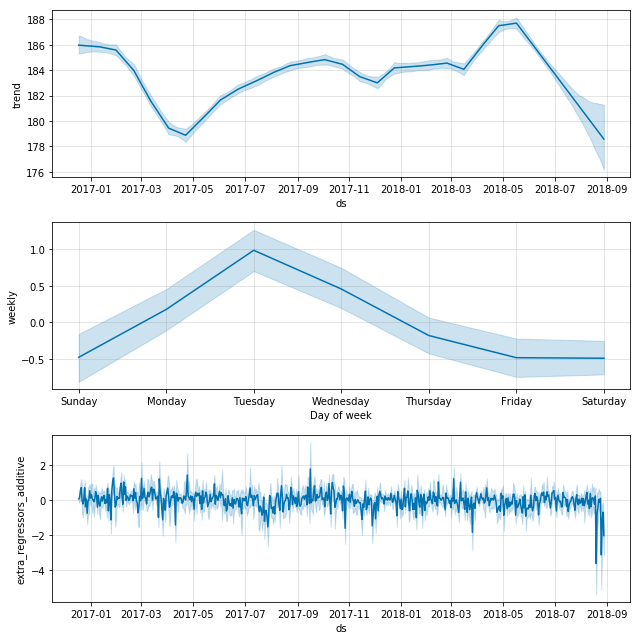

In [266]:
forecast = prophet.predict(future)
fig = prophet.plot_components(forecast)

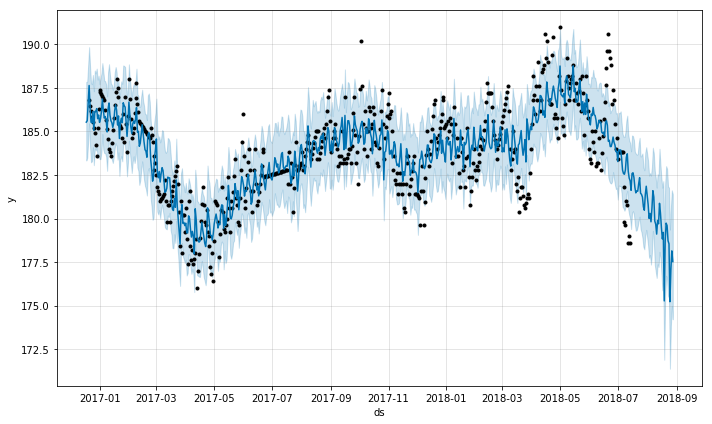

In [267]:
fig1 = prophet.plot(forecast)

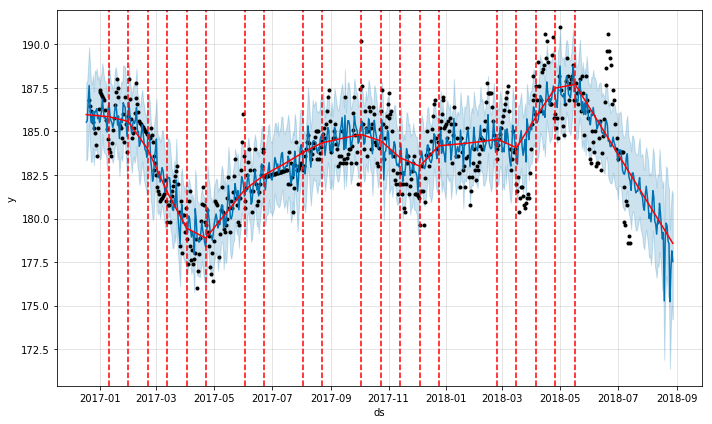

In [268]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

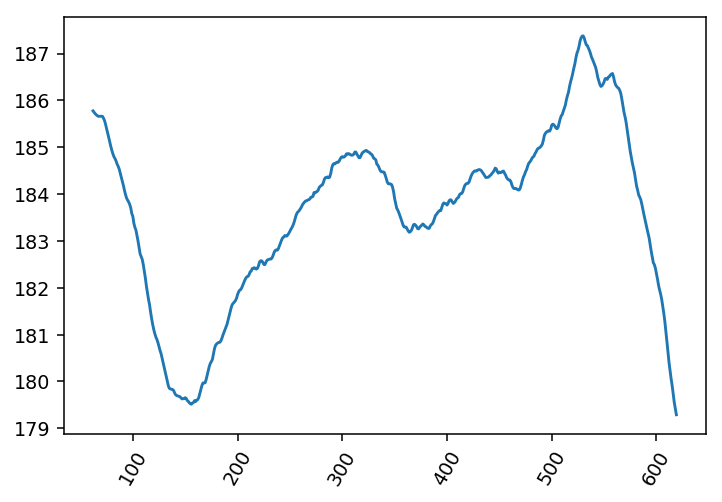

In [269]:
#df.set_index('Date', inplace=True)
df["Weight_MA60"] = df.Weight.rolling(window=60).mean()
plt.figure(dpi=138)
plt.plot(df.Weight_MA60)
plt.xticks(rotation=60);

In [270]:
len(holdout_df)

45

In [271]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Calories_Breakfast,Calories_Breakfast_lower,Calories_Breakfast_upper,Calories_Dinner,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-12-17,185.966240,183.329533,187.847614,185.299321,186.727625,-0.036942,-0.103323,0.019105,0.136514,...,0.056451,-0.162187,0.279093,-0.487427,-0.708145,-0.250158,0.0,0.0,0.0,185.535264
1,2016-12-18,185.961172,183.488642,187.854955,185.308953,186.704393,0.111186,-0.057502,0.310972,0.026536,...,0.131190,-0.106648,0.377089,-0.474673,-0.808691,-0.155324,0.0,0.0,0.0,185.617689
2,2016-12-19,185.956104,184.445357,188.821610,185.323676,186.681161,-0.057776,-0.161591,0.029880,-0.237235,...,0.526438,0.125492,0.909526,0.178153,-0.107504,0.455640,0.0,0.0,0.0,186.660695
3,2016-12-20,185.951036,185.468098,189.841033,185.334075,186.657929,-0.159590,-0.446352,0.082535,0.783080,...,0.703826,0.174840,1.193659,0.984592,0.701103,1.262607,0.0,0.0,0.0,187.639455
4,2016-12-21,185.945968,184.151105,188.739022,185.350530,186.630402,0.100225,-0.051833,0.280316,0.273227,...,-0.038917,-0.801436,0.678483,0.456828,0.196771,0.745711,0.0,0.0,0.0,186.363879
5,2016-12-22,185.940900,183.224870,187.785059,185.360804,186.591698,0.435552,-0.225254,1.218182,0.074794,...,-0.231825,-0.975872,0.602780,-0.177625,-0.421771,0.066810,0.0,0.0,0.0,185.531450
6,2016-12-23,185.935832,183.289717,187.710488,185.370640,186.550846,0.055446,-0.028675,0.155074,0.111559,...,0.039250,-0.459952,0.517723,-0.479848,-0.741973,-0.219226,0.0,0.0,0.0,185.495234
7,2016-12-24,185.930764,184.097581,188.243872,185.381879,186.529068,-0.073142,-0.204569,0.037827,0.136514,...,0.698967,0.278086,1.115945,-0.487427,-0.708145,-0.250158,0.0,0.0,0.0,186.142303
8,2016-12-25,185.925696,183.061788,187.310496,185.396725,186.502661,-0.003475,-0.009719,0.001797,0.026536,...,-0.386566,-0.856281,0.073931,-0.474673,-0.808691,-0.155324,0.0,0.0,0.0,185.064457
9,2016-12-26,185.920628,184.024580,188.501958,185.417086,186.448344,0.084415,-0.043657,0.236097,-0.237235,...,0.051620,-0.197388,0.311181,0.178153,-0.107504,0.455640,0.0,0.0,0.0,186.150401


In [272]:
forecast.columns[-13:]

Index(['additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'extra_regressors_additive', 'extra_regressors_additive_lower',
       'extra_regressors_additive_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [273]:
forecast[['additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'extra_regressors_additive', 'extra_regressors_additive_lower',
       'extra_regressors_additive_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'yhat_lower', 'yhat_upper']]

,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_lower,yhat_upper
0,-0.430976,-0.734763,-0.122226,0.056451,-0.162187,0.279093,-0.487427,-0.708145,-0.250158,0.0,0.0,0.0,185.535264,183.329533,187.847614
1,-0.343483,-0.593913,-0.069626,0.131190,-0.106648,0.377089,-0.474673,-0.808691,-0.155324,0.0,0.0,0.0,185.617689,183.488642,187.854955
2,0.704591,0.300280,1.095188,0.526438,0.125492,0.909526,0.178153,-0.107504,0.455640,0.0,0.0,0.0,186.660695,184.445357,188.821610
3,1.688419,1.146635,2.283417,0.703826,0.174840,1.193659,0.984592,0.701103,1.262607,0.0,0.0,0.0,187.639455,185.468098,189.841033
4,0.417911,-0.420702,1.185418,-0.038917,-0.801436,0.678483,0.456828,0.196771,0.745711,0.0,0.0,0.0,186.363879,184.151105,188.739022
5,-0.409450,-1.186404,0.345666,-0.231825,-0.975872,0.602780,-0.177625,-0.421771,0.066810,0.0,0.0,0.0,185.531450,183.224870,187.785059
6,-0.440597,-0.948790,0.076336,0.039250,-0.459952,0.517723,-0.479848,-0.741973,-0.219226,0.0,0.0,0.0,185.495234,183.289717,187.710488
7,0.211539,-0.264799,0.653127,0.698967,0.278086,1.115945,-0.487427,-0.708145,-0.250158,0.0,0.0,0.0,186.142303,184.097581,188.243872
8,-0.861239,-1.444846,-0.267497,-0.386566,-0.856281,0.073931,-0.474673,-0.808691,-0.155324,0.0,0.0,0.0,185.064457,183.061788,187.310496
9,0.229773,-0.016535,0.485165,0.051620,-0.197388,0.311181,0.178153,-0.107504,0.455640,0.0,0.0,0.0,186.150401,184.024580,188.501958


In [274]:
forecast.to_pickle("Data/Prophet_Forecast.pkl")

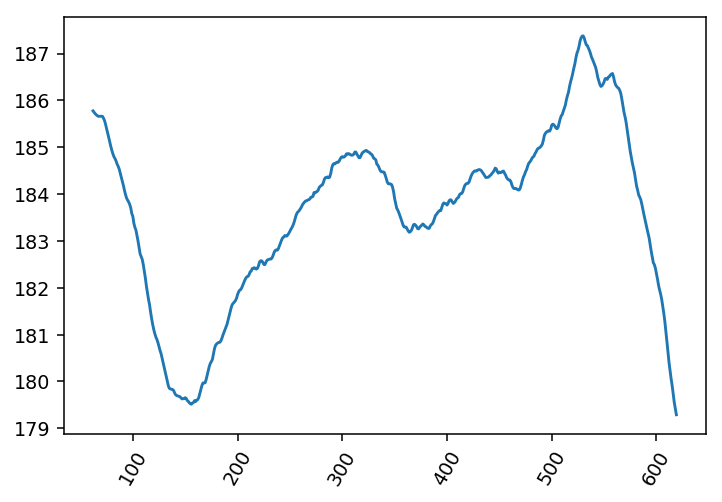

In [275]:
df["Weight_MA60"] = df.Weight.rolling(window=60).mean()
plt.figure(dpi=138)
plt.plot(df.Weight_MA60)
plt.xticks(rotation=60);

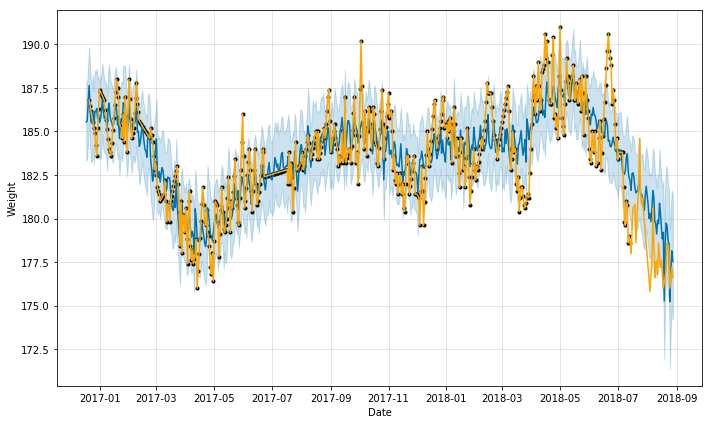

In [276]:
fig1 = prophet.plot(forecast)
df.set_index('Date', inplace=True)
fig1 = plt.plot(df.Weight, color='orange')
fig1 = plt.ylabel('Weight')
fig1 = plt.xlabel('Date')

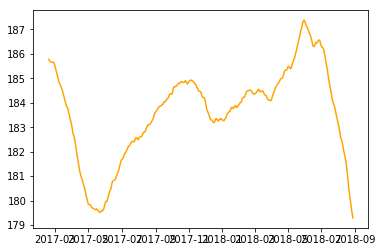

In [277]:
plt.plot(df.Weight_MA60, color='orange')

In [278]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(prophet, horizon = '30 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 31 forecasts with cutoffs between 2017-03-21 00:00:00 and 2018-06-14 00:00:00
/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-03-22,180.835285,179.085427,182.630796,182.714286,2017-03-21
1,2017-03-23,180.605060,179.091558,182.080648,183.000000,2017-03-21
2,2017-03-24,180.965795,179.668775,182.373329,182.000000,2017-03-21
3,2017-03-25,183.511745,181.861514,185.182992,180.400000,2017-03-21
4,2017-03-26,182.293506,180.453000,184.155243,178.400000,2017-03-21


In [279]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
692,3 days,4.610066,2.147106,1.694366,0.009163,0.634409
363,4 days,4.595309,2.143667,1.689958,0.009138,0.645161
33,4 days,4.547681,2.132529,1.678397,0.009075,0.645161
543,4 days,4.685047,2.164497,1.700114,0.009192,0.634409
183,4 days,4.727993,2.174395,1.714954,0.009272,0.623656


In [280]:
df_p.horizon.value_counts()

17 days    31
6 days     31
11 days    31
22 days    31
5 days     31
16 days    31
27 days    31
10 days    31
21 days    31
4 days     31
15 days    31
26 days    31
9 days     31
20 days    31
28 days    31
14 days    31
25 days    31
8 days     31
19 days    31
30 days    31
13 days    31
24 days    31
7 days     31
18 days    31
29 days    31
12 days    31
23 days    31
3 days      1
Name: horizon, dtype: int64

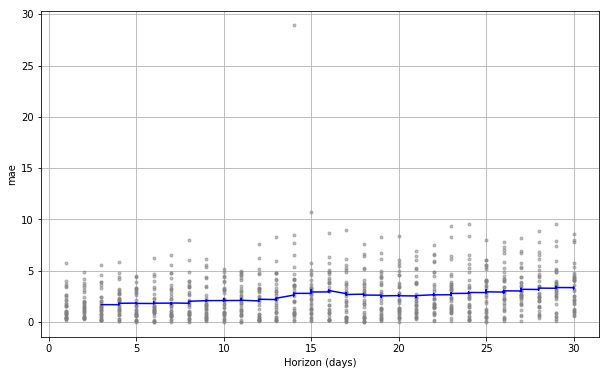

In [281]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [282]:
df_cv.tail(31)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
899,2018-06-29,188.776300,186.277841,191.299817,184.000,2018-05-30
900,2018-06-15,184.407566,182.462301,186.402709,184.750,2018-06-14
901,2018-06-16,184.354162,182.340721,186.275480,185.725,2018-06-14
902,2018-06-17,184.269530,182.239362,186.339283,186.700,2018-06-14
903,2018-06-18,184.966033,182.804357,186.876713,187.675,2018-06-14
904,2018-06-19,185.336262,183.505051,187.245232,188.650,2018-06-14
905,2018-06-20,184.975564,183.037656,186.776471,189.625,2018-06-14
906,2018-06-21,184.024814,181.954243,186.040558,190.600,2018-06-14
907,2018-06-22,183.519240,181.337927,185.628527,189.600,2018-06-14
908,2018-06-23,183.835660,182.086661,185.965445,189.200,2018-06-14


In [283]:
np.mean(df_p.mae)

2.54176878802175

In [284]:
len(df_p)

838

In [285]:
df.reset_index(inplace=True)

In [286]:
prophet_final = Prophet(mcmc_samples=100,changepoint_range=.9)

pro_final_df = df[['Date','Weight']]

pro_final_df.rename(columns={"Date": "ds", "Weight": "y"}, inplace=True)

pro_final_df

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,ds,y
0,2016-12-17,NaN
1,2016-12-18,NaN
2,2016-12-19,NaN
3,2016-12-20,186.800000
4,2016-12-21,186.483333
5,2016-12-22,186.166667
6,2016-12-23,185.850000
7,2016-12-24,185.533333
8,2016-12-25,185.216667
9,2016-12-26,184.900000


In [287]:
extra_regressors = ['Steps','Minutes_Sedentary', 'Minutes_Lightly_Active',
       'Minutes_Fairly_Active', 'Minutes_Very_Active', 'Calories_Breakfast',
       'Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast',
       'Sodium_(mg)_Breakfast',
       'Protein_(g)_Breakfast', 'Calories_Lunch', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Sodium_(mg)_Lunch',
       'Carbohydrates_(g)_Lunch', 'Sugar_Lunch', 'Protein_(g)_Lunch',
       'Calories_Dinner', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner',
       'Sodium_(mg)_Dinner', 'Carbohydrates_(g)_Dinner',
       'Sugar_Dinner', 'Protein_(g)_Dinner']

final_extra_df = df[['Date','Steps','Minutes_Sedentary', 'Minutes_Lightly_Active',
       'Minutes_Fairly_Active', 'Minutes_Very_Active', 'Calories_Breakfast',
       'Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast',
       'Sodium_(mg)_Breakfast',
       'Protein_(g)_Breakfast', 'Calories_Lunch', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Sodium_(mg)_Lunch',
       'Carbohydrates_(g)_Lunch', 'Sugar_Lunch', 'Protein_(g)_Lunch',
       'Calories_Dinner', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner',
       'Sodium_(mg)_Dinner', 'Carbohydrates_(g)_Dinner',
       'Sugar_Dinner', 'Protein_(g)_Dinner']]

for i in extra_regressors:
    pro_final_df[i] = final_extra_df[i]

pro_final_df['floor'] = 170
pro_final_df['cap'] = 200

pro_final_df

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

,ds,y,Steps,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Calories_Breakfast,Saturated_Fat_Breakfast,Cholesterol_Breakfast,...,Polyunsaturated_Fat_Dinner,Monounsaturated_Fat_Dinner,Trans_Fat_Dinner,Cholesterol_Dinner,Sodium_(mg)_Dinner,Carbohydrates_(g)_Dinner,Sugar_Dinner,Protein_(g)_Dinner,floor,cap
0,2016-12-17,NaN,7949.359551,1440.0,180.853933,8.977528,16.202247,374.499107,5.857143,103.657143,...,0.666071,1.314286,0.255357,114.707143,1050.707143,52.296429,9.191071,39.676786,170,200
1,2016-12-18,NaN,5514.820225,1440.0,102.426966,13.404494,23.292135,531.626667,9.585333,351.065333,...,0.697059,0.744118,0.282353,100.432353,1114.300000,59.961765,9.650000,42.591176,170,200
2,2016-12-19,NaN,4782.921348,1440.0,85.123596,12.157303,24.078652,352.400000,7.700000,45.000000,...,1.827907,5.158140,0.286047,147.553488,1565.016279,71.923256,10.444186,45.627907,170,200
3,2016-12-20,186.800000,6743.966292,1440.0,127.393258,9.348315,23.853933,244.400000,3.000000,20.000000,...,1.098551,2.750725,0.644928,127.798551,125.000000,30.000000,15.000000,5.000000,170,200
4,2016-12-21,186.483333,7318.181818,1440.0,148.397727,8.636364,17.397727,520.000000,3.000000,20.000000,...,0.300000,2.720430,0.054839,90.000000,4337.200000,44.000000,14.100000,47.700000,170,200
5,2016-12-22,186.166667,7112.386364,1440.0,155.465909,7.477273,14.261364,875.700000,18.600000,599.300000,...,1.374725,2.995604,0.126374,115.581319,1219.056044,56.232967,8.345055,42.856044,170,200
6,2016-12-23,185.850000,7365.511364,1440.0,145.545455,6.340909,14.215909,472.500000,3.000000,20.000000,...,1.006494,2.612987,0.097403,100.000000,165.000000,72.000000,6.942857,31.000000,170,200
7,2016-12-24,185.533333,7949.359551,1440.0,180.853933,8.977528,16.202247,336.100000,5.500000,35.000000,...,0.666071,1.314286,0.255357,114.707143,1050.707143,52.296429,9.191071,39.676786,170,200
8,2016-12-25,185.216667,5514.820225,1440.0,102.426966,13.404494,23.292135,410.000000,5.800000,11.700000,...,0.697059,0.744118,0.282353,100.432353,1114.300000,59.961765,9.650000,42.591176,170,200
9,2016-12-26,184.900000,1178.000000,1368.0,72.000000,12.157303,24.078652,503.229231,8.149231,308.261538,...,1.827907,5.158140,0.286047,147.553488,1565.016279,71.923256,10.444186,45.627907,170,200


In [288]:
for i in extra_regressors:
    prophet_final.add_regressor(i)

prophet_final.fit(pro_final_df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [289]:
pro_final_df.tail()

,ds,y,Steps,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Calories_Breakfast,Saturated_Fat_Breakfast,Cholesterol_Breakfast,...,Polyunsaturated_Fat_Dinner,Monounsaturated_Fat_Dinner,Trans_Fat_Dinner,Cholesterol_Dinner,Sodium_(mg)_Dinner,Carbohydrates_(g)_Dinner,Sugar_Dinner,Protein_(g)_Dinner,floor,cap
615,2018-08-24,178.0,10359.0,710.0,159.0,38.000000,52.000000,435.0,14.0,260.000000,...,1.006494,2.612987,0.097403,96.251948,882.441558,50.418182,6.942857,47.597403,170,200
616,2018-08-25,176.0,8696.0,820.0,221.0,39.000000,24.000000,155.0,1.5,10.000000,...,0.666071,1.314286,7.000000,84.000000,2100.000000,77.000000,9.191071,51.300000,170,200
617,2018-08-26,176.6,165.0,757.0,15.0,13.404494,23.292135,540.0,2.0,351.065333,...,0.697059,0.744118,0.282353,83.100000,2091.900000,103.300000,2.200000,45.200000,170,200
618,2018-08-27,177.2,13286.0,1247.0,103.0,9.000000,81.000000,669.1,15.6,410.900000,...,1.827907,5.158140,0.286047,50.000000,2020.000000,72.700000,15.000000,22.700000,170,200
619,2018-08-28,176.6,6360.0,1254.0,134.0,29.000000,23.000000,613.3,2.7,126.706034,...,1.098551,2.400000,0.644928,75.200000,676.000000,164.600000,6.000000,30.600000,170,200


In [299]:
example = {
  'Steps': 0.0,  # float
  'Minutes_Sedentary': 0.0,    # M or F
  'Minutes_Lightly_Active': 0.0,    # int
  'Minutes_Fairly_Active': 0.0,  # int
  'Minutes_Very_Active': 0.0,  # int
  'Saturated_Fat_Breakfast': 1.0,    # float
  'Cholesterol_Breakfast': 0.0,  # int
  'Polyunsaturated_Fat_Breakfast': 1.0,    # M or F
  'Monounsaturated_Fat_Breakfast': 0.0,    # int
  'Trans_Fat_Breakfast': 1.0,  # int
  'Carbohydrates_(g)_Breakfast': 0.0,  # int
  'Sugar_Breakfast': 0.0,    # float
  'Sodium_(mg)_Breakfast': 0.0,  # int
  'Protein_(g)_Breakfast': 1.0,    # M or F
  'Calories_Lunch': 0.0,    # int
  'Saturated_Fat_Lunch': 0.0,  # float
  'Polyunsaturated_Fat_Lunch': 0.0,    # M or F
  'Minutes_Lightly_Active': 0.0,    # int
  'Minutes_Fairly_Active': 0.0,  # int
  'Minutes_Very_Active': 0.0,  # int
  'Saturated_Fat_Breakfast': 1.0,    # float
  'Cholesterol_Breakfast': 0.0,  # int
  'Polyunsaturated_Fat_Breakfast': 1.0,    # M or F
  'Monounsaturated_Fat_Breakfast': 0.0,    # int
  'Trans_Fat_Breakfast': 1.0,  # int
  'Carbohydrates_(g)_Breakfast': 0.0,  # int
  'Sugar_Breakfast': 0.0,    # float
  'Sodium_(mg)_Breakfast': 0.0,  # int
  'Protein_(g)_Breakfast': 1.0,    # M or F
  'Calories_Lunch': 0.0,   # int
}

def prophet_forecast(df, periods, cap=None, floor=170):
    future = prophet_final.make_future_dataframe(periods=periods)
    future['floor'] = 170
    
    steps_regressors_df = df[['Date','Steps','Minutes_Sedentary', 'Minutes_Lightly_Active',
       'Minutes_Fairly_Active', 'Minutes_Very_Active', 'Calories_Breakfast',
       'Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast',
       'Sodium_(mg)_Breakfast',
       'Protein_(g)_Breakfast', 'Calories_Lunch', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Sodium_(mg)_Lunch',
       'Carbohydrates_(g)_Lunch', 'Sugar_Lunch', 'Protein_(g)_Lunch',
       'Calories_Dinner', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner',
       'Sodium_(mg)_Dinner', 'Carbohydrates_(g)_Dinner',
       'Sugar_Dinner', 'Protein_(g)_Dinner']]

    future = future.merge(steps_regressors_df, left_on='ds', right_on='Date', how='left')
    
    for i in scalable_columns:
        future[i].iloc[-periods:] = df[i].mean()
        
    forecast = prophet_final.predict(future)
        
    return forecast

In [300]:
future = prophet_final.make_future_dataframe(periods=60)

future['floor'] = 170
future['cap'] = 200

future

,ds,floor,cap
0,2016-12-17,170,200
1,2016-12-18,170,200
2,2016-12-19,170,200
3,2016-12-20,170,200
4,2016-12-21,170,200
5,2016-12-22,170,200
6,2016-12-23,170,200
7,2016-12-24,170,200
8,2016-12-25,170,200
9,2016-12-26,170,200


In [301]:
steps_regressors_df = df[['Date','Steps','Minutes_Sedentary', 'Minutes_Lightly_Active',
       'Minutes_Fairly_Active', 'Minutes_Very_Active', 'Calories_Breakfast',
       'Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast',
       'Sodium_(mg)_Breakfast',
       'Protein_(g)_Breakfast', 'Calories_Lunch', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Sodium_(mg)_Lunch',
       'Carbohydrates_(g)_Lunch', 'Sugar_Lunch', 'Protein_(g)_Lunch',
       'Calories_Dinner', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner',
       'Sodium_(mg)_Dinner', 'Carbohydrates_(g)_Dinner',
       'Sugar_Dinner', 'Protein_(g)_Dinner']]

future = future.merge(steps_regressors_df, left_on='ds', right_on='Date', how='left')

In [302]:
future

,ds,floor,cap,Date,Steps,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Calories_Breakfast,...,Calories_Dinner,Saturated_Fat_Dinner,Polyunsaturated_Fat_Dinner,Monounsaturated_Fat_Dinner,Trans_Fat_Dinner,Cholesterol_Dinner,Sodium_(mg)_Dinner,Carbohydrates_(g)_Dinner,Sugar_Dinner,Protein_(g)_Dinner
0,2016-12-17,170,200,2016-12-17,7949.359551,1440.0,180.853933,8.977528,16.202247,374.499107,...,612.128571,7.269643,0.666071,1.314286,0.255357,114.707143,1050.707143,52.296429,9.191071,39.676786
1,2016-12-18,170,200,2016-12-18,5514.820225,1440.0,102.426966,13.404494,23.292135,531.626667,...,686.482353,12.223529,0.697059,0.744118,0.282353,100.432353,1114.300000,59.961765,9.650000,42.591176
2,2016-12-19,170,200,2016-12-19,4782.921348,1440.0,85.123596,12.157303,24.078652,352.400000,...,864.811628,11.144186,1.827907,5.158140,0.286047,147.553488,1565.016279,71.923256,10.444186,45.627907
3,2016-12-20,170,200,2016-12-20,6743.966292,1440.0,127.393258,9.348315,23.853933,244.400000,...,175.000000,7.760870,1.098551,2.750725,0.644928,127.798551,125.000000,30.000000,15.000000,5.000000
4,2016-12-21,170,200,2016-12-21,7318.181818,1440.0,148.397727,8.636364,17.397727,520.000000,...,519.700000,2.300000,0.300000,2.720430,0.054839,90.000000,4337.200000,44.000000,14.100000,47.700000
5,2016-12-22,170,200,2016-12-22,7112.386364,1440.0,155.465909,7.477273,14.261364,875.700000,...,653.856044,7.624176,1.374725,2.995604,0.126374,115.581319,1219.056044,56.232967,8.345055,42.856044
6,2016-12-23,170,200,2016-12-23,7365.511364,1440.0,145.545455,6.340909,14.215909,472.500000,...,629.000000,11.500000,1.006494,2.612987,0.097403,100.000000,165.000000,72.000000,6.942857,31.000000
7,2016-12-24,170,200,2016-12-24,7949.359551,1440.0,180.853933,8.977528,16.202247,336.100000,...,612.128571,7.269643,0.666071,1.314286,0.255357,114.707143,1050.707143,52.296429,9.191071,39.676786
8,2016-12-25,170,200,2016-12-25,5514.820225,1440.0,102.426966,13.404494,23.292135,410.000000,...,686.482353,12.223529,0.697059,0.744118,0.282353,100.432353,1114.300000,59.961765,9.650000,42.591176
9,2016-12-26,170,200,2016-12-26,1178.000000,1368.0,72.000000,12.157303,24.078652,503.229231,...,864.811628,11.144186,1.827907,5.158140,0.286047,147.553488,1565.016279,71.923256,10.444186,45.627907


In [303]:
for i in scalable_columns:
    future[i].iloc[-60:] = df[i].mean()

future

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,ds,floor,cap,Date,Steps,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Calories_Breakfast,...,Calories_Dinner,Saturated_Fat_Dinner,Polyunsaturated_Fat_Dinner,Monounsaturated_Fat_Dinner,Trans_Fat_Dinner,Cholesterol_Dinner,Sodium_(mg)_Dinner,Carbohydrates_(g)_Dinner,Sugar_Dinner,Protein_(g)_Dinner
0,2016-12-17,170,200,2016-12-17,7949.359551,1440.000000,180.853933,8.977528,16.202247,374.499107,...,612.128571,7.269643,0.666071,1.314286,0.255357,114.707143,1050.707143,52.296429,9.191071,39.676786
1,2016-12-18,170,200,2016-12-18,5514.820225,1440.000000,102.426966,13.404494,23.292135,531.626667,...,686.482353,12.223529,0.697059,0.744118,0.282353,100.432353,1114.300000,59.961765,9.650000,42.591176
2,2016-12-19,170,200,2016-12-19,4782.921348,1440.000000,85.123596,12.157303,24.078652,352.400000,...,864.811628,11.144186,1.827907,5.158140,0.286047,147.553488,1565.016279,71.923256,10.444186,45.627907
3,2016-12-20,170,200,2016-12-20,6743.966292,1440.000000,127.393258,9.348315,23.853933,244.400000,...,175.000000,7.760870,1.098551,2.750725,0.644928,127.798551,125.000000,30.000000,15.000000,5.000000
4,2016-12-21,170,200,2016-12-21,7318.181818,1440.000000,148.397727,8.636364,17.397727,520.000000,...,519.700000,2.300000,0.300000,2.720430,0.054839,90.000000,4337.200000,44.000000,14.100000,47.700000
5,2016-12-22,170,200,2016-12-22,7112.386364,1440.000000,155.465909,7.477273,14.261364,875.700000,...,653.856044,7.624176,1.374725,2.995604,0.126374,115.581319,1219.056044,56.232967,8.345055,42.856044
6,2016-12-23,170,200,2016-12-23,7365.511364,1440.000000,145.545455,6.340909,14.215909,472.500000,...,629.000000,11.500000,1.006494,2.612987,0.097403,100.000000,165.000000,72.000000,6.942857,31.000000
7,2016-12-24,170,200,2016-12-24,7949.359551,1440.000000,180.853933,8.977528,16.202247,336.100000,...,612.128571,7.269643,0.666071,1.314286,0.255357,114.707143,1050.707143,52.296429,9.191071,39.676786
8,2016-12-25,170,200,2016-12-25,5514.820225,1440.000000,102.426966,13.404494,23.292135,410.000000,...,686.482353,12.223529,0.697059,0.744118,0.282353,100.432353,1114.300000,59.961765,9.650000,42.591176
9,2016-12-26,170,200,2016-12-26,1178.000000,1368.000000,72.000000,12.157303,24.078652,503.229231,...,864.811628,11.144186,1.827907,5.158140,0.286047,147.553488,1565.016279,71.923256,10.444186,45.627907


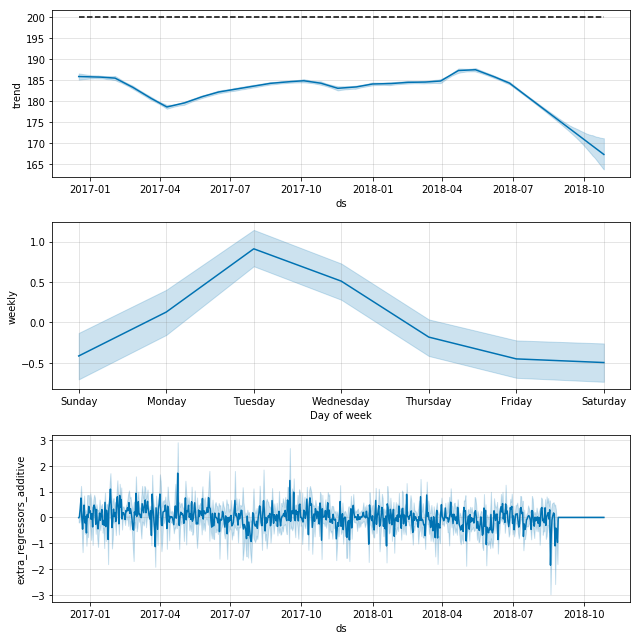

In [304]:
forecast = prophet_final.predict(future)
fig = prophet_final.plot_components(forecast)

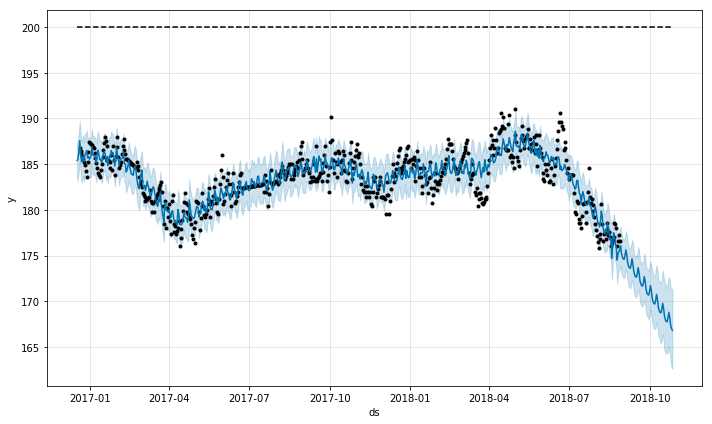

In [305]:
fig = prophet_final.plot(forecast)

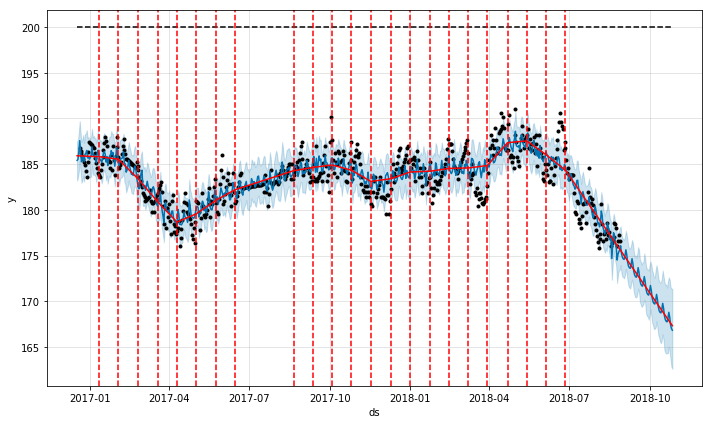

In [320]:
fig = prophet_final.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_final, forecast)

In [306]:
forecast.tail(75)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,Calories_Breakfast,Calories_Breakfast_lower,Calories_Breakfast_upper,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
605,2018-08-14,177.648011,200,176.206549,180.725925,177.293173,178.010121,0.152424,-0.571072,0.855605,...,0.006260,-0.723050,0.812507,0.910272,0.694147,1.144367,0.0,0.0,0.0,178.564543
606,2018-08-15,177.508587,200,176.024609,180.396706,177.142797,177.876182,-0.026781,-0.150330,0.100338,...,0.113820,-0.294488,0.569608,0.510157,0.279633,0.728108,0.0,0.0,0.0,178.132563
607,2018-08-16,177.369162,200,175.295533,179.534353,176.992421,177.749090,-0.099703,-0.559663,0.373546,...,0.183230,-0.314758,0.750265,-0.182432,-0.416265,0.036259,0.0,0.0,0.0,177.369960
608,2018-08-17,177.229738,200,174.665171,178.954992,176.846535,177.621999,0.029733,-0.111399,0.166902,...,-0.065388,-0.569635,0.452433,-0.452142,-0.686275,-0.223481,0.0,0.0,0.0,176.712208
609,2018-08-18,177.090314,200,174.718845,178.750504,176.702532,177.494908,0.066413,-0.248823,0.372797,...,0.293590,-0.112921,0.661070,-0.497236,-0.735677,-0.260931,0.0,0.0,0.0,176.886668
610,2018-08-19,176.950890,200,172.352836,177.106805,176.554241,177.367608,-0.004540,-0.025484,0.017009,...,-1.853312,-2.978915,-0.525997,-0.416002,-0.705794,-0.130958,0.0,0.0,0.0,174.681576
611,2018-08-20,176.811465,200,173.995561,178.602739,176.407545,177.234706,-0.046105,-0.258804,0.172738,...,-0.671290,-1.548045,0.354081,0.127384,-0.156000,0.402711,0.0,0.0,0.0,176.267559
612,2018-08-21,176.672041,200,175.512766,179.563439,176.264290,177.100561,0.015149,-0.056757,0.085036,...,-0.089634,-0.701257,0.542411,0.910272,0.694147,1.144367,0.0,0.0,0.0,177.492679
613,2018-08-22,176.532617,200,174.962655,179.178512,176.121199,176.961651,0.015149,-0.056757,0.085036,...,0.063876,-0.389822,0.559350,0.510157,0.279633,0.728108,0.0,0.0,0.0,177.106649
614,2018-08-23,176.393193,200,174.334488,178.310320,175.978108,176.833741,-0.041365,-0.232197,0.154980,...,0.173209,-0.219220,0.590768,-0.182432,-0.416265,0.036259,0.0,0.0,0.0,176.383970


In [307]:
ninety_day_forecast = prophet_forecast(df,periods=90)

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [308]:
ninety_day_forecast.to_pickle("Models/Prophet_90_Forecast.pkl")

In [309]:
ninety_day_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Calories_Breakfast,Calories_Breakfast_lower,Calories_Breakfast_upper,Calories_Dinner,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-12-17,185.918483,183.336710,187.679338,185.165013,186.657491,-0.014202,-0.079722,0.053211,0.129440,...,-0.012588,-0.192291,0.175578,-0.497236,-0.735677,-0.260931,0.0,0.0,0.0,185.408660
1,2016-12-18,185.914508,183.409905,187.547992,185.184703,186.628660,0.043088,-0.161432,0.241865,0.026145,...,0.026595,-0.198144,0.267909,-0.416002,-0.705794,-0.130958,0.0,0.0,0.0,185.525102
2,2016-12-19,185.910534,184.312599,188.661565,185.204393,186.600815,-0.022260,-0.124952,0.083399,-0.221597,...,0.348108,-0.006761,0.736204,0.127384,-0.156000,0.402711,0.0,0.0,0.0,186.386025
3,2016-12-20,185.906559,185.481503,189.706335,185.224981,186.574629,-0.061638,-0.345992,0.230931,0.736717,...,0.752068,0.235865,1.220249,0.910272,0.694147,1.144367,0.0,0.0,0.0,187.568898
4,2016-12-21,185.902584,184.231737,188.659682,185.252613,186.545625,0.038849,-0.145550,0.218069,0.257846,...,-0.005903,-0.605234,0.652986,0.510157,0.279633,0.728108,0.0,0.0,0.0,186.406837
5,2016-12-22,185.898609,182.979324,187.454902,185.283515,186.510495,0.168540,-0.631451,0.946067,0.071471,...,-0.455068,-1.347189,0.337674,-0.182432,-0.416265,0.036259,0.0,0.0,0.0,185.261110
6,2016-12-23,185.894635,183.371233,187.699601,185.298813,186.481667,0.021530,-0.080663,0.120852,0.106002,...,0.062189,-0.372017,0.517982,-0.452142,-0.686275,-0.223481,0.0,0.0,0.0,185.504682
7,2016-12-24,185.890660,183.812588,187.946165,185.314052,186.461658,-0.028203,-0.158312,0.105665,0.129440,...,0.476394,0.080502,0.849174,-0.497236,-0.735677,-0.260931,0.0,0.0,0.0,185.869818
8,2016-12-25,185.886685,183.053871,187.504923,185.329290,186.431606,-0.001258,-0.007064,0.004715,0.026145,...,-0.213839,-0.643377,0.193258,-0.416002,-0.705794,-0.130958,0.0,0.0,0.0,185.256845
9,2016-12-26,185.882710,183.989769,188.187051,185.344246,186.412505,0.032734,-0.122640,0.183745,-0.221597,...,0.034462,-0.228602,0.277800,0.127384,-0.156000,0.402711,0.0,0.0,0.0,186.044556


In [310]:
ninety_day_forecast.iloc[709]

ds                                   2018-11-26 00:00:00
trend                                            163.148
yhat_lower                                       156.848
yhat_upper                                       170.053
trend_lower                                      157.157
trend_upper                                      169.855
Calories_Breakfast                           1.06862e-05
Calories_Breakfast_lower                    -4.00368e-05
Calories_Breakfast_upper                     5.99848e-05
Calories_Dinner                              -0.00010647
Calories_Dinner_lower                       -0.000190521
Calories_Dinner_upper                        -2.8634e-05
Calories_Lunch                              -1.94716e-05
Calories_Lunch_lower                        -9.49924e-05
Calories_Lunch_upper                         5.54782e-05
Carbohydrates_(g)_Breakfast                  0.000136024
Carbohydrates_(g)_Breakfast_lower            -0.00020489
Carbohydrates_(g)_Breakfast_upp

In [311]:
ninety_day_forecast[ninety_day_forecast['ds'] == '2018-11-25']['yhat'].values[0]

162.8718960896033

In [312]:
import pickle

pickle.dump(prophet_final, open("Models/Prophet_Final.pkl", 'wb'))

In [313]:
df.describe()['Protein_(g)_Breakfast']['mean']

23.22047111735793

In [314]:
example = {
  'Steps': df.describe()['Steps']['mean'],  
  'Minutes_Sedentary': df.describe()['Minutes_Sedentary']['mean'],    
  'Minutes_Lightly_Active': df.describe()['Minutes_Lightly_Active']['mean'],    
  'Minutes_Fairly_Active': df.describe()['Minutes_Fairly_Active']['mean'],  
  'Minutes_Very_Active': df.describe()['Minutes_Very_Active']['mean'],  
  'Calories_Breakfast': df.describe()['Calories_Breakfast']['mean'],
  'Saturated_Fat_Breakfast': df.describe()['Saturated_Fat_Breakfast']['mean'],    
  'Cholesterol_Breakfast': df.describe()['Cholesterol_Breakfast']['mean'],  
  'Polyunsaturated_Fat_Breakfast': df.describe()['Polyunsaturated_Fat_Breakfast']['mean'],    
  'Monounsaturated_Fat_Breakfast': df.describe()['Monounsaturated_Fat_Breakfast']['mean'],    
  'Trans_Fat_Breakfast': df.describe()['Trans_Fat_Breakfast']['mean'],  
  'Carbohydrates_(g)_Breakfast': df.describe()['Carbohydrates_(g)_Breakfast']['mean'],  
  'Sugar_Breakfast': df.describe()['Sugar_Breakfast']['mean'],    
  'Sodium_(mg)_Breakfast': df.describe()['Sodium_(mg)_Breakfast']['mean'],  
  'Protein_(g)_Breakfast': df.describe()['Protein_(g)_Breakfast']['mean'],    
  'Calories_Lunch': df.describe()['Calories_Lunch']['mean'],    
  'Saturated_Fat_Lunch': df.describe()['Saturated_Fat_Lunch']['mean'],  
  'Polyunsaturated_Fat_Lunch': df.describe()['Polyunsaturated_Fat_Lunch']['mean'],    
  'Monounsaturated_Fat_Lunch': df.describe()['Monounsaturated_Fat_Lunch']['mean'],    
  'Trans_Fat_Lunch': df.describe()['Trans_Fat_Lunch']['mean'],  
  'Cholesterol_Lunch': df.describe()['Cholesterol_Lunch']['mean'],  
  'Sodium_(mg)_Lunch': df.describe()['Sodium_(mg)_Lunch']['mean'],    
  'Carbohydrates_(g)_Lunch': df.describe()['Carbohydrates_(g)_Lunch']['mean'],  
  'Sugar_Lunch': df.describe()['Sugar_Lunch']['mean'],    
  'Protein_(g)_Lunch': df.describe()['Protein_(g)_Lunch']['mean'],    
  'Calories_Dinner': df.describe()['Calories_Dinner']['mean'],  
  'Saturated_Fat_Dinner': df.describe()['Saturated_Fat_Dinner']['mean'],  
  'Polyunsaturated_Fat_Dinner': df.describe()['Polyunsaturated_Fat_Dinner']['mean'],    
  'Monounsaturated_Fat_Dinner': df.describe()['Monounsaturated_Fat_Dinner']['mean'],  
  'Trans_Fat_Dinner': df.describe()['Trans_Fat_Dinner']['mean'],    
  'Cholesterol_Dinner': df.describe()['Cholesterol_Dinner']['mean'],   
  'Sodium_(mg)_Dinner': df.describe()['Sodium_(mg)_Dinner']['mean'],    
  'Carbohydrates_(g)_Dinner': df.describe()['Carbohydrates_(g)_Dinner']['mean'],  
  'Sugar_Dinner': df.describe()['Sugar_Dinner']['mean'],    
  'Protein_(g)_Dinner': df.describe()['Protein_(g)_Dinner']['mean'],   
}

def prophet_forecast_weight(features, df, periods, date, cap=None, floor=170):
    future = prophet_final.make_future_dataframe(periods=periods)
    future['floor'] = 170
    
    steps_regressors_df = df[['Date','Steps','Minutes_Sedentary', 'Minutes_Lightly_Active',
       'Minutes_Fairly_Active', 'Minutes_Very_Active', 'Calories_Breakfast',
       'Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast',
       'Sodium_(mg)_Breakfast',
       'Protein_(g)_Breakfast', 'Calories_Lunch', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Sodium_(mg)_Lunch',
       'Carbohydrates_(g)_Lunch', 'Sugar_Lunch', 'Protein_(g)_Lunch',
       'Calories_Dinner', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner',
       'Sodium_(mg)_Dinner', 'Carbohydrates_(g)_Dinner',
       'Sugar_Dinner', 'Protein_(g)_Dinner']]
    
    columns = ['Steps','Minutes_Sedentary', 'Minutes_Lightly_Active',
       'Minutes_Fairly_Active', 'Minutes_Very_Active', 'Calories_Breakfast',
       'Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast',
       'Sodium_(mg)_Breakfast',
       'Protein_(g)_Breakfast', 'Calories_Lunch', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Sodium_(mg)_Lunch',
       'Carbohydrates_(g)_Lunch', 'Sugar_Lunch', 'Protein_(g)_Lunch',
       'Calories_Dinner', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner',
       'Sodium_(mg)_Dinner', 'Carbohydrates_(g)_Dinner',
       'Sugar_Dinner', 'Protein_(g)_Dinner']

    future = future.merge(steps_regressors_df, left_on='ds', right_on='Date', how='left')
    
    for i in columns:
        future[i].iloc[-periods:] = features[i]
        
    forecast = prophet_final.predict(future)
    
    predicted_weight = np.round(forecast[forecast['ds'] == date]['yhat'].values[0],2)
    predicted_weight_upper = np.round(forecast[forecast['ds'] == date]['yhat_upper'].values[0],2)
    predicted_weight_lower = np.round(forecast[forecast['ds'] == date]['yhat_lower'].values[0],2)
    
    result = {
        
        'predicted_weight':predicted_weight,
        'predicted_weight_upper': predicted_weight_upper,
        'predicted_weight_lower': predicted_weight_lower
        
    }
        
    return result

In [315]:
df

,Date,Steps,Distance,Calories_Burned,Floors,Elevation,Activity_Calories,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,...,Fiber_Dinner,Sugar_Dinner,Protein_(g)_Dinner,Vitamin_A_Dinner,Vitamin_C_Dinner,Calcium_Dinner,Iron_Dinner,Weight,Net_Calories,Weight_MA60
0,2016-12-17,7949.359551,6.100120,1856.0,6.528090,19.629213,1059.067416,1440.0,180.853933,8.977528,...,4.801786,9.191071,39.676786,9.469643,16.176786,9.782143,11.300000,NaN,NaN,NaN
1,2016-12-18,5514.820225,4.235007,1855.0,7.089888,21.438202,781.202247,1440.0,102.426966,13.404494,...,4.600000,9.650000,42.591176,13.979412,20.058824,25.000000,24.091176,NaN,NaN,NaN
2,2016-12-19,4782.921348,3.679812,1855.0,5.146067,15.494382,702.179775,1440.0,85.123596,12.157303,...,5.353488,10.444186,45.627907,17.386047,54.534884,10.860465,23.369767,NaN,-1110.2,NaN
3,2016-12-20,6743.966292,5.175902,1855.0,4.640449,13.977528,869.786517,1440.0,127.393258,9.348315,...,10.000000,15.000000,5.000000,40.000000,125.000000,10.000000,10.000000,186.800000,-660.1,NaN
4,2016-12-21,7318.181818,5.671428,1854.0,5.215909,15.704545,911.261364,1440.0,148.397727,8.636364,...,1.900000,14.100000,47.700000,18.000000,48.800000,2.500000,25.400000,186.483333,-154.3,NaN
5,2016-12-22,7112.386364,5.472372,1854.0,3.909091,11.761364,899.102273,1440.0,155.465909,7.477273,...,4.378022,8.345055,42.856044,11.289011,16.280220,11.697802,21.106593,186.166667,-978.3,NaN
6,2016-12-23,7365.511364,5.715491,1854.0,4.420455,13.284091,857.477273,1440.0,145.545455,6.340909,...,4.000000,6.942857,31.000000,9.000000,12.935065,24.000000,23.000000,185.850000,-142.5,NaN
7,2016-12-24,7949.359551,6.100120,1853.0,6.528090,19.629213,1059.067416,1440.0,180.853933,8.977528,...,4.801786,9.191071,39.676786,9.469643,16.176786,9.782143,11.300000,185.533333,-1036.9,NaN
8,2016-12-25,5514.820225,4.235007,1853.0,7.089888,21.438202,781.202247,1440.0,102.426966,13.404494,...,4.600000,9.650000,42.591176,13.979412,20.058824,25.000000,24.091176,185.216667,-903.0,NaN
9,2016-12-26,1178.000000,0.882320,2074.0,3.000000,9.000000,268.000000,1368.0,72.000000,12.157303,...,5.353488,10.444186,45.627907,17.386047,54.534884,10.860465,23.369767,184.900000,NaN,NaN


In [316]:
df.to_pickle("Data/Prophet_Forecast_DF.pkl")

In [317]:
prophet_forecast_weight(example, df, periods=90, date='2018-09-11')

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


{'predicted_weight': 174.65,
 'predicted_weight_lower': 172.53,
 'predicted_weight_upper': 176.77}

In [ ]:
np.mean(df['Fat (g)'])

In [ ]:
np.mean(df['Saturated_Fat_Breakfast'])

In [ ]:
fat_breakdown = {}

mean_fat = np.mean(df['Fat (g)'])

fat_columns = ['Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Sodium_(mg)_Breakfast', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch','Sodium_(mg)_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner','Sodium_(mg)_Dinner']

for i in fat_columns:
    fat_breakdown[i] = np.mean(df[i]) / mean_fat
    
protein_breakdown = {}

mean_protein = np.mean(df['Protein (g)'])

protein_columns = ['Protein_(g)_Breakfast', 'Protein_(g)_Lunch','Protein_(g)_Dinner']

for i in protein_columns:
    protein_breakdown[i] = np.mean(df[i]) / mean_protein
    
carb_breakdown = {}

mean_carb = np.mean(df['Carbohydrates (g)'])

carb_columns = ['Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast','Carbohydrates_(g)_Lunch',
                         'Sugar_Lunch','Carbohydrates_(g)_Dinner','Sugar_Dinner']

for i in carb_columns:
    carb_breakdown[i] = np.mean(df[i]) / mean_carb
    
fat_breakdown

In [ ]:
protein_breakdown

In [ ]:
carb_breakdown

In [ ]:
0.3*2000*3.04517

In [ ]:
np.mean(df.Cholesterol_Breakfast)

In [ ]:
np.mean(df['Fat (g)'])

In [ ]:
fat_per_cal = np.mean(df['Fat (g)']) / np.mean(df['Calories'])

In [ ]:
fat_per_cal

In [ ]:
## USE THIS AS MEASURE FOR FINAL BREAKFAST CHOLESTEROL

mean_fat * 3.04517 * (2000/np.mean(df['Calories']))

In [ ]:
np.mean(df['Calories'])

In [ ]:
for key, value in fat_breakdown:
    

In [ ]:
df[['Weight', 'Steps', 'Distance', 'Floors', 'Elevation', 'Minutes_Sedentary', 'Minutes_Lightly_Active',
    'Minutes_Fairly_Active', 'Minutes_Very_Active']].corr()

In [ ]:
sns.pairplot(df[['Weight', 'Steps', 'Distance', 'Floors', 'Elevation', 'Minutes_Sedentary', 'Minutes_Lightly_Active',
    'Minutes_Fairly_Active', 'Minutes_Very_Active']].dropna())

In [ ]:
df.columns

In [ ]:
sns.pairplot(df[['Weight', 'Calories', 'Fat (g)',
       'Saturated Fat', 'Polyunsaturated Fat', 'Monounsaturated Fat',
       'Trans Fat', 'Cholesterol', 'Sodium (mg)', 'Potassium',
       'Carbohydrates (g)', 'Fiber', 'Sugar', 'Protein (g)', 'Vitamin A',
       'Vitamin C', 'Calcium', 'Iron']].dropna())

In [335]:
nutrient_breakdown = { 
  'Calories_Breakfast': df.describe()['Calories_Breakfast']['mean'],
  'Saturated_Fat_Breakfast_per_total_fat': df.describe()['Saturated_Fat_Breakfast']['mean'],    
  'Cholesterol_Breakfast': df.describe()['Cholesterol_Breakfast']['mean'],  
  'Polyunsaturated_Fat_Breakfast': df.describe()['Polyunsaturated_Fat_Breakfast']['mean'],    
  'Monounsaturated_Fat_Breakfast': df.describe()['Monounsaturated_Fat_Breakfast']['mean'],    
  'Trans_Fat_Breakfast': df.describe()['Trans_Fat_Breakfast']['mean'],  
  'Carbohydrates_(g)_Breakfast': df.describe()['Carbohydrates_(g)_Breakfast']['mean'],  
  'Sugar_Breakfast': df.describe()['Sugar_Breakfast']['mean'],    
  'Sodium_(mg)_Breakfast': df.describe()['Sodium_(mg)_Breakfast']['mean'],  
  'Protein_(g)_Breakfast': df.describe()['Protein_(g)_Breakfast']['mean'],    
  'Calories_Lunch': df.describe()['Calories_Lunch']['mean'],    
  'Saturated_Fat_Lunch': df.describe()['Saturated_Fat_Lunch']['mean'],  
  'Polyunsaturated_Fat_Lunch': df.describe()['Polyunsaturated_Fat_Lunch']['mean'],    
  'Monounsaturated_Fat_Lunch': df.describe()['Monounsaturated_Fat_Lunch']['mean'],    
  'Trans_Fat_Lunch': df.describe()['Trans_Fat_Lunch']['mean'],  
  'Cholesterol_Lunch': df.describe()['Cholesterol_Lunch']['mean'],  
  'Sodium_(mg)_Lunch': df.describe()['Sodium_(mg)_Lunch']['mean'],    
  'Carbohydrates_(g)_Lunch': df.describe()['Carbohydrates_(g)_Lunch']['mean'],  
  'Sugar_Lunch': df.describe()['Sugar_Lunch']['mean'],    
  'Protein_(g)_Lunch': df.describe()['Protein_(g)_Lunch']['mean'],    
  'Calories_Dinner': df.describe()['Calories_Dinner']['mean'],  
  'Saturated_Fat_Dinner': df.describe()['Saturated_Fat_Dinner']['mean'],  
  'Polyunsaturated_Fat_Dinner': df.describe()['Polyunsaturated_Fat_Dinner']['mean'],    
  'Monounsaturated_Fat_Dinner': df.describe()['Monounsaturated_Fat_Dinner']['mean'],  
  'Trans_Fat_Dinner': df.describe()['Trans_Fat_Dinner']['mean'],    
  'Cholesterol_Dinner': df.describe()['Cholesterol_Dinner']['mean'],   
  'Sodium_(mg)_Dinner': df.describe()['Sodium_(mg)_Dinner']['mean'],    
  'Carbohydrates_(g)_Dinner': df.describe()['Carbohydrates_(g)_Dinner']['mean'],  
  'Sugar_Dinner': df.describe()['Sugar_Dinner']['mean'],    
  'Protein_(g)_Dinner': df.describe()['Protein_(g)_Dinner']['mean'],   
}

cals_per_g_fat = 9
cals_per_g_protein = 4
cals_per_g_carb = 4

percent_fat = 0.3
percent_protein = 0.4
percent_carb = 0.3

percent_breakfast = 0.2
percent_lunch = 0.4
percent_dinner = 0.4

breakfast_multiplier = percent_breakfast / np.mean(df['Calories_Breakfast'] / df['Calories'])
lunch_multiplier = percent_lunch / np.mean(df['Calories_Lunch'] / df['Calories'])
dinner_multiplier = percent_dinner / np.mean(df['Calories_Dinner'] / df['Calories'])

total_calories = 2000

g_fat = total_calories * percent_fat / cals_per_g_fat
g_protein = total_calories * percent_protein / cals_per_g_protein
g_carbs = total_calories * percent_carb / cals_per_g_carb

fat_multiplier = g_fat / np.mean(df['Fat (g)'])
protein_multiplier = g_protein / np.mean(df['Protein (g)'])
carb_multiplier = g_carbs / np.mean(df['Carbohydrates (g)'])

fat_breakdown = {}

fat_columns = ['Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
       'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
       'Trans_Fat_Breakfast', 'Sodium_(mg)_Breakfast', 'Saturated_Fat_Lunch',
       'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch','Sodium_(mg)_Lunch',
       'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
       'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner','Sodium_(mg)_Dinner']

for i in range(len(fat_columns)):
    if i <= 5:
        fat_breakdown[fat_columns[i]] = np.mean(df[fat_columns[i]]) * fat_multiplier * percent_breakfast
    elif i <= 11:
        fat_breakdown[fat_columns[i]] = np.mean(df[fat_columns[i]]) * fat_multiplier * percent_lunch
    else:
        fat_breakdown[fat_columns[i]] = np.mean(df[fat_columns[i]]) * fat_multiplier * percent_dinner
    
protein_breakdown = {}

protein_columns = ['Protein_(g)_Breakfast', 'Protein_(g)_Lunch','Protein_(g)_Dinner']

for i in range(len(protein_columns)):
    if i == 0:
        protein_breakdown[protein_columns[i]] = np.mean(df[protein_columns[i]]) * protein_multiplier * percent_breakfast
    elif i == 1:
        protein_breakdown[protein_columns[i]] = np.mean(df[protein_columns[i]]) * protein_multiplier * percent_lunch
    else:
        protein_breakdown[protein_columns[i]] = np.mean(df[protein_columns[i]]) * protein_multiplier * percent_dinner
    
carb_breakdown = {}

carb_columns = ['Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast','Carbohydrates_(g)_Lunch',
                         'Sugar_Lunch','Carbohydrates_(g)_Dinner','Sugar_Dinner']

for i in range(len(carb_columns)):
    if i <= 1:
        carb_breakdown[carb_columns[i]] = np.mean(df[carb_columns[i]]) * carb_multiplier * percent_breakfast
    elif i <= 3:
        carb_breakdown[carb_columns[i]] = np.mean(df[carb_columns[i]]) * carb_multiplier * percent_lunch
    else:
        carb_breakdown[carb_columns[i]] = np.mean(df[carb_columns[i]]) * carb_multiplier * percent_dinner
    
fat_breakdown

{'Cholesterol_Breakfast': 40.60231005619733,
 'Cholesterol_Dinner': 51.40220482695311,
 'Cholesterol_Lunch': 45.191225254118194,
 'Monounsaturated_Fat_Breakfast': 0.9145697161413852,
 'Monounsaturated_Fat_Dinner': 1.491146096768675,
 'Monounsaturated_Fat_Lunch': 1.438265478099358,
 'Polyunsaturated_Fat_Breakfast': 0.38512351521894184,
 'Polyunsaturated_Fat_Dinner': 0.6935707168416184,
 'Polyunsaturated_Fat_Lunch': 1.138796337260181,
 'Saturated_Fat_Breakfast': 1.471117289188469,
 'Saturated_Fat_Dinner': 4.014723134121505,
 'Saturated_Fat_Lunch': 3.296311720115882,
 'Sodium_(mg)_Breakfast': 162.09272781881938,
 'Sodium_(mg)_Dinner': 500.3243507477157,
 'Sodium_(mg)_Lunch': 534.7276746706418,
 'Trans_Fat_Breakfast': 0.04888789787786778,
 'Trans_Fat_Dinner': 0.12967739231370043,
 'Trans_Fat_Lunch': 0.031657579798590206}

In [327]:
np.mean(df.Cholesterol_Breakfast)

194.08576444786743

In [328]:
fat_multiplier

1.0459888743438304

In [350]:
def nutritional_breakdown(df, converted_data):

    total_calories = converted_data['Daily_Calories']
    percent_fat = converted_data['Daily_Fat']
    percent_protein = converted_data['Daily_Protein']
    percent_carb = converted_data['Daily_Carbs']
    percent_breakfast = converted_data['Percent_Breakfast']
    percent_lunch = converted_data['Percent_Lunch']
    percent_dinner = converted_data['Percent_Dinner']
    
    nutrient_breakdown = { 
      'Calories_Breakfast': df.describe()['Calories_Breakfast']['mean'],
      'Saturated_Fat_Breakfast_per_total_fat': df.describe()['Saturated_Fat_Breakfast']['mean'],    
      'Cholesterol_Breakfast': df.describe()['Cholesterol_Breakfast']['mean'],  
      'Polyunsaturated_Fat_Breakfast': df.describe()['Polyunsaturated_Fat_Breakfast']['mean'],    
      'Monounsaturated_Fat_Breakfast': df.describe()['Monounsaturated_Fat_Breakfast']['mean'],    
      'Trans_Fat_Breakfast': df.describe()['Trans_Fat_Breakfast']['mean'],  
      'Carbohydrates_(g)_Breakfast': df.describe()['Carbohydrates_(g)_Breakfast']['mean'],  
      'Sugar_Breakfast': df.describe()['Sugar_Breakfast']['mean'],    
      'Sodium_(mg)_Breakfast': df.describe()['Sodium_(mg)_Breakfast']['mean'],  
      'Protein_(g)_Breakfast': df.describe()['Protein_(g)_Breakfast']['mean'],    
      'Calories_Lunch': df.describe()['Calories_Lunch']['mean'],    
      'Saturated_Fat_Lunch': df.describe()['Saturated_Fat_Lunch']['mean'],  
      'Polyunsaturated_Fat_Lunch': df.describe()['Polyunsaturated_Fat_Lunch']['mean'],    
      'Monounsaturated_Fat_Lunch': df.describe()['Monounsaturated_Fat_Lunch']['mean'],    
      'Trans_Fat_Lunch': df.describe()['Trans_Fat_Lunch']['mean'],  
      'Cholesterol_Lunch': df.describe()['Cholesterol_Lunch']['mean'],  
      'Sodium_(mg)_Lunch': df.describe()['Sodium_(mg)_Lunch']['mean'],    
      'Carbohydrates_(g)_Lunch': df.describe()['Carbohydrates_(g)_Lunch']['mean'],  
      'Sugar_Lunch': df.describe()['Sugar_Lunch']['mean'],    
      'Protein_(g)_Lunch': df.describe()['Protein_(g)_Lunch']['mean'],    
      'Calories_Dinner': df.describe()['Calories_Dinner']['mean'],  
      'Saturated_Fat_Dinner': df.describe()['Saturated_Fat_Dinner']['mean'],  
      'Polyunsaturated_Fat_Dinner': df.describe()['Polyunsaturated_Fat_Dinner']['mean'],    
      'Monounsaturated_Fat_Dinner': df.describe()['Monounsaturated_Fat_Dinner']['mean'],  
      'Trans_Fat_Dinner': df.describe()['Trans_Fat_Dinner']['mean'],    
      'Cholesterol_Dinner': df.describe()['Cholesterol_Dinner']['mean'],   
      'Sodium_(mg)_Dinner': df.describe()['Sodium_(mg)_Dinner']['mean'],    
      'Carbohydrates_(g)_Dinner': df.describe()['Carbohydrates_(g)_Dinner']['mean'],  
      'Sugar_Dinner': df.describe()['Sugar_Dinner']['mean'],    
      'Protein_(g)_Dinner': df.describe()['Protein_(g)_Dinner']['mean'],   
    }

    cals_per_g_fat = 9
    cals_per_g_protein = 4
    cals_per_g_carb = 4

    percent_fat = 0.3
    percent_protein = 0.4
    percent_carb = 0.3

    percent_breakfast = 0.2
    percent_lunch = 0.4
    percent_dinner = 0.4

    breakfast_multiplier = percent_breakfast / np.mean(df['Calories_Breakfast'] / df['Calories'])
    lunch_multiplier = percent_lunch / np.mean(df['Calories_Lunch'] / df['Calories'])
    dinner_multiplier = percent_dinner / np.mean(df['Calories_Dinner'] / df['Calories'])

    total_calories = 2000

    g_fat = total_calories * percent_fat / cals_per_g_fat
    g_protein = total_calories * percent_protein / cals_per_g_protein
    g_carbs = total_calories * percent_carb / cals_per_g_carb

    fat_multiplier = g_fat / np.mean(df['Fat (g)'])
    protein_multiplier = g_protein / np.mean(df['Protein (g)'])
    carb_multiplier = g_carbs / np.mean(df['Carbohydrates (g)'])

    fat_breakdown = {}

    fat_columns = ['Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
           'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
           'Trans_Fat_Breakfast', 'Sodium_(mg)_Breakfast', 'Saturated_Fat_Lunch',
           'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch','Sodium_(mg)_Lunch',
           'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
           'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner','Sodium_(mg)_Dinner']

    for i in range(len(fat_columns)):
        if i <= 5:
            fat_breakdown[fat_columns[i]] = np.mean(df[fat_columns[i]]) * fat_multiplier * percent_breakfast
        elif i <= 11:
            fat_breakdown[fat_columns[i]] = np.mean(df[fat_columns[i]]) * fat_multiplier * percent_lunch
        else:
            fat_breakdown[fat_columns[i]] = np.mean(df[fat_columns[i]]) * fat_multiplier * percent_dinner

    protein_breakdown = {}

    protein_columns = ['Protein_(g)_Breakfast', 'Protein_(g)_Lunch','Protein_(g)_Dinner']

    for i in range(len(protein_columns)):
        if i == 0:
            protein_breakdown[protein_columns[i]] = np.mean(df[protein_columns[i]]) * protein_multiplier * percent_breakfast
        elif i == 1:
            protein_breakdown[protein_columns[i]] = np.mean(df[protein_columns[i]]) * protein_multiplier * percent_lunch
        else:
            protein_breakdown[protein_columns[i]] = np.mean(df[protein_columns[i]]) * protein_multiplier * percent_dinner

    carb_breakdown = {}

    carb_columns = ['Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast','Carbohydrates_(g)_Lunch',
                             'Sugar_Lunch','Carbohydrates_(g)_Dinner','Sugar_Dinner']

    for i in range(len(carb_columns)):
        if i <= 1:
            carb_breakdown[carb_columns[i]] = np.mean(df[carb_columns[i]]) * carb_multiplier * percent_breakfast
        elif i <= 3:
            carb_breakdown[carb_columns[i]] = np.mean(df[carb_columns[i]]) * carb_multiplier * percent_lunch
        else:
            carb_breakdown[carb_columns[i]] = np.mean(df[carb_columns[i]]) * carb_multiplier * percent_dinner
    
    return fat_breakdown, protein_breakdown, carb_breakdown

In [337]:
nutritional_breakdown(df, total_calories = 1800, percent_fat = 0.3, percent_protein=0.4, percent_carb=0.3,
                     percent_breakfast=0.2, percent_lunch=0.4, percent_dinner=0.4)

({'Cholesterol_Breakfast': 40.60231005619733,
  'Cholesterol_Dinner': 51.40220482695311,
  'Cholesterol_Lunch': 45.191225254118194,
  'Monounsaturated_Fat_Breakfast': 0.9145697161413852,
  'Monounsaturated_Fat_Dinner': 1.491146096768675,
  'Monounsaturated_Fat_Lunch': 1.438265478099358,
  'Polyunsaturated_Fat_Breakfast': 0.38512351521894184,
  'Polyunsaturated_Fat_Dinner': 0.6935707168416184,
  'Polyunsaturated_Fat_Lunch': 1.138796337260181,
  'Saturated_Fat_Breakfast': 1.471117289188469,
  'Saturated_Fat_Dinner': 4.014723134121505,
  'Saturated_Fat_Lunch': 3.296311720115882,
  'Sodium_(mg)_Breakfast': 162.09272781881938,
  'Sodium_(mg)_Dinner': 500.3243507477157,
  'Sodium_(mg)_Lunch': 534.7276746706418,
  'Trans_Fat_Breakfast': 0.04888789787786778,
  'Trans_Fat_Dinner': 0.12967739231370043,
  'Trans_Fat_Lunch': 0.031657579798590206},
 {'Protein_(g)_Breakfast': 11.091942365553132,
  'Protein_(g)_Dinner': 42.45146186529735,
  'Protein_(g)_Lunch': 39.57893389150156},
 {'Carbohydrates_(g

In [342]:
def nutritional_breakdown(df, total_calories, percent_fat, percent_protein, percent_carb,
                          percent_breakfast, percent_lunch, percent_dinner):
    nutrient_breakdown = {
        'Calories_Breakfast': np.mean(df['Calories_Breakfast']),
        'Saturated_Fat_Breakfast': np.mean(df['Saturated_Fat_Breakfast']),
        'Cholesterol_Breakfast': np.mean(df['Cholesterol_Breakfast']),
        'Polyunsaturated_Fat_Breakfast': np.mean(df['Polyunsaturated_Fat_Breakfast']),
        'Monounsaturated_Fat_Breakfast': np.mean(df['Monounsaturated_Fat_Breakfast']),
        'Trans_Fat_Breakfast': np.mean(df['Trans_Fat_Breakfast']),
        'Carbohydrates_(g)_Breakfast': np.mean(df['Carbohydrates_(g)_Breakfast']),
        'Sugar_Breakfast': np.mean(df['Sugar_Breakfast']),
        'Sodium_(mg)_Breakfast': np.mean(df['Sodium_(mg)_Breakfast']),
        'Protein_(g)_Breakfast': np.mean(df['Protein_(g)_Breakfast']),
        'Calories_Lunch': np.mean(df['Calories_Lunch']),
        'Saturated_Fat_Lunch': np.mean(df['Saturated_Fat_Lunch']),
        'Polyunsaturated_Fat_Lunch': np.mean(df['Polyunsaturated_Fat_Lunch']),
        'Monounsaturated_Fat_Lunch': np.mean(df['Monounsaturated_Fat_Lunch']),
        'Trans_Fat_Lunch': np.mean(df['Trans_Fat_Lunch']),
        'Cholesterol_Lunch': np.mean(df['Cholesterol_Lunch']),
        'Sodium_(mg)_Lunch': np.mean(df['Sodium_(mg)_Lunch']),
        'Carbohydrates_(g)_Lunch': np.mean(df['Carbohydrates_(g)_Lunch']),
        'Sugar_Lunch': np.mean(df['Sugar_Lunch']),
        'Protein_(g)_Lunch': np.mean(df['Protein_(g)_Lunch']),
        'Calories_Dinner': np.mean(df['Calories_Dinner']),
        'Saturated_Fat_Dinner': np.mean(df['Saturated_Fat_Dinner']),
        'Polyunsaturated_Fat_Dinner': np.mean(df['Polyunsaturated_Fat_Dinner']),
        'Monounsaturated_Fat_Dinner': np.mean(df['Monounsaturated_Fat_Dinner']),
        'Trans_Fat_Dinner': np.mean(df['Trans_Fat_Dinner']),
        'Cholesterol_Dinner': np.mean(df['Cholesterol_Dinner']),
        'Sodium_(mg)_Dinner': np.mean(df['Sodium_(mg)_Dinner']),
        'Carbohydrates_(g)_Dinner': np.mean(df['Carbohydrates_(g)_Dinner']),
        'Sugar_Dinner': np.mean(df['Sugar_Dinner']),
        'Protein_(g)_Dinner': np.mean(df['Protein_(g)_Dinner'])
    }

    cals_per_g_fat = 9
    cals_per_g_protein = 4
    cals_per_g_carb = 4

    percent_fat = 0.3
    percent_protein = 0.4
    percent_carb = 0.3

    percent_breakfast = 0.2
    percent_lunch = 0.4
    percent_dinner = 0.4

    breakfast_multiplier = percent_breakfast / np.mean(df['Calories_Breakfast'] / df['Calories'])
    lunch_multiplier = percent_lunch / np.mean(df['Calories_Lunch'] / df['Calories'])
    dinner_multiplier = percent_dinner / np.mean(df['Calories_Dinner'] / df['Calories'])

    g_fat = total_calories * percent_fat / cals_per_g_fat
    g_protein = total_calories * percent_protein / cals_per_g_protein
    g_carbs = total_calories * percent_carb / cals_per_g_carb

    fat_multiplier = g_fat / np.mean(df['Fat (g)'])
    protein_multiplier = g_protein / np.mean(df['Protein (g)'])
    carb_multiplier = g_carbs / np.mean(df['Carbohydrates (g)'])

    fat_breakdown = {}

    fat_columns = ['Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
                   'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
                   'Trans_Fat_Breakfast', 'Sodium_(mg)_Breakfast', 'Saturated_Fat_Lunch',
                   'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch', 'Sodium_(mg)_Lunch',
                   'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
                   'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner', 'Sodium_(mg)_Dinner']

    for i in range(len(fat_columns)):
        if i <= 5:
            fat_breakdown[fat_columns[i]] = nutrient_breakdown[fat_columns[i]] * \
                fat_multiplier * percent_breakfast
        elif i <= 11:
            fat_breakdown[fat_columns[i]] = nutrient_breakdown[fat_columns[i]] * \
                fat_multiplier * percent_lunch
        else:
            fat_breakdown[fat_columns[i]] = nutrient_breakdown[fat_columns[i]] * \
                fat_multiplier * percent_dinner

    protein_breakdown = {}

    protein_columns = ['Protein_(g)_Breakfast', 'Protein_(g)_Lunch', 'Protein_(g)_Dinner']
    
    protein_breakdown['Protein_(g)_Breakfast'] = nutrient_breakdown['Protein_(g)_Breakfast'] * protein_multiplier * percent_breakfast
    protein_breakdown['Protein_(g)_Lunch'] = nutrient_breakdown['Protein_(g)_Lunch'] * protein_multiplier * percent_lunch
    protein_breakdown['Protein_(g)_Dinner'] = nutrient_breakdown['Protein_(g)_Dinner'] * protein_multiplier * percent_dinner
    
    carb_breakdown = {}

    carb_columns = ['Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast', 'Carbohydrates_(g)_Lunch',
                    'Sugar_Lunch', 'Carbohydrates_(g)_Dinner', 'Sugar_Dinner']

    for i in range(len(carb_columns)):
        if i <= 1:
            carb_breakdown[carb_columns[i]] = nutrient_breakdown[carb_columns[i]] * \
                carb_multiplier * percent_breakfast
        elif i <= 3:
            carb_breakdown[carb_columns[i]] = nutrient_breakdown[carb_columns[i]] * \
                carb_multiplier * percent_lunch
        else:
            carb_breakdown[carb_columns[i]] = nutrient_breakdown[carb_columns[i]] * \
                carb_multiplier * percent_dinner
                
    calories_breakdown = {}
    
    calories_columns = ['Calories_Breakfast','Calories_Lunch','Calories_Dinner']
    
    calories_breakdown['Calories_Breakfast'] = total_calories * percent_breakfast
    calories_breakdown['Calories_Lunch'] = total_calories * percent_lunch
    calories_breakdown['Calories_Dinner'] = total_calories * percent_dinner
                                     

    return fat_breakdown, protein_breakdown, carb_breakdown, calories_breakdown

In [343]:
nutritional_breakdown(df, total_calories = 1800, percent_fat = 0.3, percent_protein=0.4, percent_carb=0.3,
                     percent_breakfast=0.2, percent_lunch=0.4, percent_dinner=0.4)

({'Cholesterol_Breakfast': 36.5420790505776,
  'Cholesterol_Dinner': 46.2619843442578,
  'Cholesterol_Lunch': 40.67210272870637,
  'Monounsaturated_Fat_Breakfast': 0.8231127445272466,
  'Monounsaturated_Fat_Dinner': 1.3420314870918073,
  'Monounsaturated_Fat_Lunch': 1.2944389302894221,
  'Polyunsaturated_Fat_Breakfast': 0.34661116369704764,
  'Polyunsaturated_Fat_Dinner': 0.6242136451574566,
  'Polyunsaturated_Fat_Lunch': 1.024916703534163,
  'Saturated_Fat_Breakfast': 1.324005560269622,
  'Saturated_Fat_Dinner': 3.6132508207093545,
  'Saturated_Fat_Lunch': 2.9666805481042937,
  'Sodium_(mg)_Breakfast': 145.88345503693742,
  'Sodium_(mg)_Dinner': 450.291915672944,
  'Sodium_(mg)_Lunch': 481.2549072035776,
  'Trans_Fat_Breakfast': 0.043999108090081,
  'Trans_Fat_Dinner': 0.11670965308233039,
  'Trans_Fat_Lunch': 0.028491821818731184},
 {'Protein_(g)_Breakfast': 9.98274812899782,
  'Protein_(g)_Dinner': 38.20631567876761,
  'Protein_(g)_Lunch': 35.621040502351406},
 {'Carbohydrates_(g)_B

In [345]:
fat_breakdown, protein_breakdown, carb_breakdown, calories_breakdown = nutritional_breakdown(df, total_calories = 1800, percent_fat = 0.3, percent_protein=0.4, percent_carb=0.3,
                     percent_breakfast=0.2, percent_lunch=0.4, percent_dinner=0.4)

fat_breakdown

{'Cholesterol_Breakfast': 36.5420790505776,
 'Cholesterol_Dinner': 46.2619843442578,
 'Cholesterol_Lunch': 40.67210272870637,
 'Monounsaturated_Fat_Breakfast': 0.8231127445272466,
 'Monounsaturated_Fat_Dinner': 1.3420314870918073,
 'Monounsaturated_Fat_Lunch': 1.2944389302894221,
 'Polyunsaturated_Fat_Breakfast': 0.34661116369704764,
 'Polyunsaturated_Fat_Dinner': 0.6242136451574566,
 'Polyunsaturated_Fat_Lunch': 1.024916703534163,
 'Saturated_Fat_Breakfast': 1.324005560269622,
 'Saturated_Fat_Dinner': 3.6132508207093545,
 'Saturated_Fat_Lunch': 2.9666805481042937,
 'Sodium_(mg)_Breakfast': 145.88345503693742,
 'Sodium_(mg)_Dinner': 450.291915672944,
 'Sodium_(mg)_Lunch': 481.2549072035776,
 'Trans_Fat_Breakfast': 0.043999108090081,
 'Trans_Fat_Dinner': 0.11670965308233039,
 'Trans_Fat_Lunch': 0.028491821818731184}

In [346]:
fat_breakdown['Cholesterol_Breakfast']

36.5420790505776

In [347]:
calories_breakdown

{'Calories_Breakfast': 360.0,
 'Calories_Dinner': 720.0,
 'Calories_Lunch': 720.0}

In [354]:
def nutritional_breakdown(df, converted_data):

    total_calories = converted_data['Daily_Calories']
    percent_fat = converted_data['Daily_Fat']
    percent_protein = converted_data['Daily_Protein']
    percent_carb = converted_data['Daily_Carbs']
    percent_breakfast = converted_data['Percent_Breakfast']
    percent_lunch = converted_data['Percent_Lunch']
    percent_dinner = converted_data['Percent_Dinner']

    nutrient_breakdown = {
        'Calories_Breakfast': np.mean(df['Calories_Breakfast']),
        'Saturated_Fat_Breakfast': np.mean(df['Saturated_Fat_Breakfast']),
        'Cholesterol_Breakfast': np.mean(df['Cholesterol_Breakfast']),
        'Polyunsaturated_Fat_Breakfast': np.mean(df['Polyunsaturated_Fat_Breakfast']),
        'Monounsaturated_Fat_Breakfast': np.mean(df['Monounsaturated_Fat_Breakfast']),
        'Trans_Fat_Breakfast': np.mean(df['Trans_Fat_Breakfast']),
        'Carbohydrates_(g)_Breakfast': np.mean(df['Carbohydrates_(g)_Breakfast']),
        'Sugar_Breakfast': np.mean(df['Sugar_Breakfast']),
        'Sodium_(mg)_Breakfast': np.mean(df['Sodium_(mg)_Breakfast']),
        'Protein_(g)_Breakfast': np.mean(df['Protein_(g)_Breakfast']),
        'Calories_Lunch': np.mean(df['Calories_Lunch']),
        'Saturated_Fat_Lunch': np.mean(df['Saturated_Fat_Lunch']),
        'Polyunsaturated_Fat_Lunch': np.mean(df['Polyunsaturated_Fat_Lunch']),
        'Monounsaturated_Fat_Lunch': np.mean(df['Monounsaturated_Fat_Lunch']),
        'Trans_Fat_Lunch': np.mean(df['Trans_Fat_Lunch']),
        'Cholesterol_Lunch': np.mean(df['Cholesterol_Lunch']),
        'Sodium_(mg)_Lunch': np.mean(df['Sodium_(mg)_Lunch']),
        'Carbohydrates_(g)_Lunch': np.mean(df['Carbohydrates_(g)_Lunch']),
        'Sugar_Lunch': np.mean(df['Sugar_Lunch']),
        'Protein_(g)_Lunch': np.mean(df['Protein_(g)_Lunch']),
        'Calories_Dinner': np.mean(df['Calories_Dinner']),
        'Saturated_Fat_Dinner': np.mean(df['Saturated_Fat_Dinner']),
        'Polyunsaturated_Fat_Dinner': np.mean(df['Polyunsaturated_Fat_Dinner']),
        'Monounsaturated_Fat_Dinner': np.mean(df['Monounsaturated_Fat_Dinner']),
        'Trans_Fat_Dinner': np.mean(df['Trans_Fat_Dinner']),
        'Cholesterol_Dinner': np.mean(df['Cholesterol_Dinner']),
        'Sodium_(mg)_Dinner': np.mean(df['Sodium_(mg)_Dinner']),
        'Carbohydrates_(g)_Dinner': np.mean(df['Carbohydrates_(g)_Dinner']),
        'Sugar_Dinner': np.mean(df['Sugar_Dinner']),
        'Protein_(g)_Dinner': np.mean(df['Protein_(g)_Dinner'])
    }

    cals_per_g_fat = 9
    cals_per_g_protein = 4
    cals_per_g_carb = 4
    
    percent_breakfast = percent_breakfast / 100
    percent_lunch = percent_lunch / 100
    percent_dinner = percent_dinner / 100
    
    percent_fat = percent_fat / 100
    percent_protein = percent_protein / 100
    percent_carb = percent_carb / 100

    breakfast_multiplier = percent_breakfast / np.mean(df['Calories_Breakfast'] / df['Calories'])
    lunch_multiplier = percent_lunch / np.mean(df['Calories_Lunch'] / df['Calories'])
    dinner_multiplier = percent_dinner / np.mean(df['Calories_Dinner'] / df['Calories'])

    g_fat = total_calories * percent_fat / cals_per_g_fat
    g_protein = total_calories * percent_protein / cals_per_g_protein
    g_carbs = total_calories * percent_carb / cals_per_g_carb

    fat_multiplier = g_fat / np.mean(df['Fat (g)'])
    protein_multiplier = g_protein / np.mean(df['Protein (g)'])
    carb_multiplier = g_carbs / np.mean(df['Carbohydrates (g)'])

    fat_breakdown = {}

    fat_columns = ['Saturated_Fat_Breakfast', 'Cholesterol_Breakfast',
                   'Polyunsaturated_Fat_Breakfast', 'Monounsaturated_Fat_Breakfast',
                   'Trans_Fat_Breakfast', 'Sodium_(mg)_Breakfast', 'Saturated_Fat_Lunch',
                   'Polyunsaturated_Fat_Lunch', 'Monounsaturated_Fat_Lunch', 'Sodium_(mg)_Lunch',
                   'Trans_Fat_Lunch', 'Cholesterol_Lunch', 'Saturated_Fat_Dinner', 'Polyunsaturated_Fat_Dinner',
                   'Monounsaturated_Fat_Dinner', 'Trans_Fat_Dinner', 'Cholesterol_Dinner', 'Sodium_(mg)_Dinner']

    for i in range(len(fat_columns)):
        if i <= 5:
            fat_breakdown[fat_columns[i]] = nutrient_breakdown[fat_columns[i]] * \
                fat_multiplier * percent_breakfast
        elif i <= 11:
            fat_breakdown[fat_columns[i]] = nutrient_breakdown[fat_columns[i]] * \
                fat_multiplier * percent_lunch
        else:
            fat_breakdown[fat_columns[i]] = nutrient_breakdown[fat_columns[i]] * \
                fat_multiplier * percent_dinner

    protein_breakdown = {}

    protein_columns = ['Protein_(g)_Breakfast', 'Protein_(g)_Lunch', 'Protein_(g)_Dinner']

    protein_breakdown['Protein_(g)_Breakfast'] = nutrient_breakdown['Protein_(g)_Breakfast'] * \
        protein_multiplier * percent_breakfast
    protein_breakdown['Protein_(g)_Lunch'] = nutrient_breakdown['Protein_(g)_Lunch'] * \
        protein_multiplier * percent_lunch
    protein_breakdown['Protein_(g)_Dinner'] = nutrient_breakdown['Protein_(g)_Dinner'] * \
        protein_multiplier * percent_dinner

    carb_breakdown = {}

    carb_columns = ['Carbohydrates_(g)_Breakfast', 'Sugar_Breakfast', 'Carbohydrates_(g)_Lunch',
                    'Sugar_Lunch', 'Carbohydrates_(g)_Dinner', 'Sugar_Dinner']

    for i in range(len(carb_columns)):
        if i <= 1:
            carb_breakdown[carb_columns[i]] = nutrient_breakdown[carb_columns[i]] * \
                carb_multiplier * percent_breakfast
        elif i <= 3:
            carb_breakdown[carb_columns[i]] = nutrient_breakdown[carb_columns[i]] * \
                carb_multiplier * percent_lunch
        else:
            carb_breakdown[carb_columns[i]] = nutrient_breakdown[carb_columns[i]] * \
                carb_multiplier * percent_dinner

    calories_breakdown = {}

    calories_columns = ['Calories_Breakfast', 'Calories_Lunch', 'Calories_Dinner']

    calories_breakdown['Calories_Breakfast'] = total_calories * percent_breakfast
    calories_breakdown['Calories_Lunch'] = total_calories * percent_lunch
    calories_breakdown['Calories_Dinner'] = total_calories * percent_dinner

    return fat_breakdown, protein_breakdown, carb_breakdown, calories_breakdown

In [355]:
def get_features(converted_data, fat_breakdown, protein_breakdown, carb_breakdown, calorie_breakdown):
    minutes_sedentary = (1440 - converted_data['Minutes_Lightly_Active'] -
                         converted_data['Minutes_Fairly_Active'] - converted_data['Minutes_Very_Active'])

    features = {
        'Steps': converted_data['Steps'],
        'Minutes_Sedentary': minutes_sedentary,
        'Minutes_Lightly_Active': converted_data['Minutes_Lightly_Active'],
        'Minutes_Fairly_Active': converted_data['Minutes_Fairly_Active'],
        'Minutes_Very_Active': converted_data['Minutes_Very_Active'],
        'Calories_Breakfast': calorie_breakdown['Calories_Breakfast'],
        'Saturated_Fat_Breakfast': fat_breakdown['Saturated_Fat_Breakfast'],
        'Cholesterol_Breakfast': fat_breakdown['Cholesterol_Breakfast'],
        'Polyunsaturated_Fat_Breakfast': fat_breakdown['Polyunsaturated_Fat_Breakfast'],
        'Monounsaturated_Fat_Breakfast': fat_breakdown['Monounsaturated_Fat_Breakfast'],
        'Trans_Fat_Breakfast': fat_breakdown['Trans_Fat_Breakfast'],
        'Carbohydrates_(g)_Breakfast': carb_breakdown['Carbohydrates_(g)_Breakfast'],
        'Sugar_Breakfast': carb_breakdown['Sugar_Breakfast'],
        'Sodium_(mg)_Breakfast': fat_breakdown['Sodium_(mg)_Breakfast'],
        'Protein_(g)_Breakfast': protein_breakdown['Protein_(g)_Breakfast'],
        'Calories_Lunch': calorie_breakdown['Calories_Lunch'],
        'Saturated_Fat_Lunch': fat_breakdown['Saturated_Fat_Lunch'],
        'Polyunsaturated_Fat_Lunch': fat_breakdown['Polyunsaturated_Fat_Lunch'],
        'Monounsaturated_Fat_Lunch': fat_breakdown['Monounsaturated_Fat_Lunch'],
        'Trans_Fat_Lunch': fat_breakdown['Trans_Fat_Lunch'],
        'Cholesterol_Lunch': fat_breakdown['Cholesterol_Lunch'],
        'Sodium_(mg)_Lunch': fat_breakdown['Sodium_(mg)_Lunch'],
        'Carbohydrates_(g)_Lunch': carb_breakdown['Carbohydrates_(g)_Lunch'],
        'Sugar_Lunch': carb_breakdown['Sugar_Lunch'],
        'Protein_(g)_Lunch': protein_breakdown['Protein_(g)_Lunch'],
        'Calories_Dinner': calorie_breakdown['Calories_Dinner'],
        'Saturated_Fat_Dinner': fat_breakdown['Saturated_Fat_Dinner'],
        'Polyunsaturated_Fat_Dinner': fat_breakdown['Polyunsaturated_Fat_Dinner'],
        'Monounsaturated_Fat_Dinner': fat_breakdown['Monounsaturated_Fat_Dinner'],
        'Trans_Fat_Dinner': fat_breakdown['Trans_Fat_Dinner'],
        'Cholesterol_Dinner': fat_breakdown['Cholesterol_Dinner'],
        'Sodium_(mg)_Dinner': fat_breakdown['Sodium_(mg)_Dinner'],
        'Carbohydrates_(g)_Dinner': carb_breakdown['Carbohydrates_(g)_Dinner'],
        'Sugar_Dinner': carb_breakdown['Sugar_Dinner'],
        'Protein_(g)_Dinner': protein_breakdown['Protein_(g)_Dinner']
    }

    return features

In [356]:
converted_data = {
  'Steps': 10000,
  'Minutes_Lightly_Active': 100,
  'Minutes_Fairly_Active': 60,
  'Minutes_Very_Active': 20,
  'Daily_Calories': 2000,
  'Percent_Breakfast': 20,
  'Percent_Lunch': 40,
  'Percent_Dinner': 40,
  'Daily_Fat': 35,
  'Daily_Carbs': 25,
  'Daily_Protein': 40,
  'Date': '2018-10-01'
}

fat_breakdown, protein_breakdown, carb_breakdown, calorie_breakdown = nutritional_breakdown(
        df, converted_data)

fat_breakdown

{'Cholesterol_Breakfast': 47.369361732230225,
 'Cholesterol_Dinner': 59.96923896477862,
 'Cholesterol_Lunch': 52.72309612980455,
 'Monounsaturated_Fat_Breakfast': 1.0669980021649492,
 'Monounsaturated_Fat_Dinner': 1.7396704462301207,
 'Monounsaturated_Fat_Lunch': 1.6779763911159176,
 'Polyunsaturated_Fat_Breakfast': 0.44931076775543205,
 'Polyunsaturated_Fat_Dinner': 0.8091658363152215,
 'Polyunsaturated_Fat_Lunch': 1.3285957268035444,
 'Saturated_Fat_Breakfast': 1.7163035040532133,
 'Saturated_Fat_Dinner': 4.683843656475089,
 'Saturated_Fat_Lunch': 3.845697006801862,
 'Sodium_(mg)_Breakfast': 189.10818245528924,
 'Sodium_(mg)_Dinner': 583.7117425390015,
 'Sodium_(mg)_Lunch': 623.8489537824153,
 'Trans_Fat_Breakfast': 0.057035880857512405,
 'Trans_Fat_Dinner': 0.15129029103265051,
 'Trans_Fat_Lunch': 0.036933843098355235}

In [357]:
features = get_features(converted_data, fat_breakdown, protein_breakdown,
                            carb_breakdown, calorie_breakdown)

features

{'Calories_Breakfast': 400.0,
 'Calories_Dinner': 800.0,
 'Calories_Lunch': 800.0,
 'Carbohydrates_(g)_Breakfast': 7.622350343519052,
 'Carbohydrates_(g)_Dinner': 23.595488384569848,
 'Carbohydrates_(g)_Lunch': 24.440668196871435,
 'Cholesterol_Breakfast': 47.369361732230225,
 'Cholesterol_Dinner': 59.96923896477862,
 'Cholesterol_Lunch': 52.72309612980455,
 'Minutes_Fairly_Active': 60,
 'Minutes_Lightly_Active': 100,
 'Minutes_Sedentary': 1260,
 'Minutes_Very_Active': 20,
 'Monounsaturated_Fat_Breakfast': 1.0669980021649492,
 'Monounsaturated_Fat_Dinner': 1.7396704462301207,
 'Monounsaturated_Fat_Lunch': 1.6779763911159176,
 'Polyunsaturated_Fat_Breakfast': 0.44931076775543205,
 'Polyunsaturated_Fat_Dinner': 0.8091658363152215,
 'Polyunsaturated_Fat_Lunch': 1.3285957268035444,
 'Protein_(g)_Breakfast': 11.091942365553132,
 'Protein_(g)_Dinner': 42.45146186529735,
 'Protein_(g)_Lunch': 39.57893389150156,
 'Saturated_Fat_Breakfast': 1.7163035040532133,
 'Saturated_Fat_Dinner': 4.6838436

In [358]:
prophet_forecast_weight(features, df, periods=90, date=converted_data['Date'])

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


{'predicted_weight': 171.21,
 'predicted_weight_lower': 168.62,
 'predicted_weight_upper': 174.12}